#Coastal

Import the necessary libraries

In [1]:
#Import the necessary libraries
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle
import joblib
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, matthews_corrcoef, roc_auc_score, jaccard_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

Load the data set

In [2]:
# Load coastal data from Excel file into a DataFrame
df_coastal = pd.read_excel("https://raw.githubusercontent.com/Ricardo8932/ProyectoConagua/main/Database/Coastal/coastal_results.xlsx")

In [3]:
# Creates a new DataFrame for nullity matrix (nm) from the years 2012 to 2021, excluding data for the year 2022
df_nm_2012_2021 = df_coastal[df_coastal['AÑO'] != 2022]

# Creates a new DataFrame for nullity matrix (nm) consisting only of data from the year 2022
df_nm_2022 = df_coastal[df_coastal['AÑO'] == 2022]

In [4]:
# Display the first 5 rows of the coastal DataFrame
df_coastal.head(5)

,CLAVE SITIO,CLAVE MONITOREO,NOMBRE DEL SITIO,TIPO CUERPO DE AGUA,FECHA REALIZACIÓN,AÑO,TSS,FC,ODs%,ODm%,ODb%,FE,TF15s,TF15b
0,DLBAJ100,DLBAJ100-281012,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2012-11-12,2012,<10,<3,90.1,89.5,95.1,10,<1,<1
1,DLBAJ100,DLBAJ100-231212,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-01-07,2013,24,41,82.1,NaN,85.5,<3,<1,<1
2,DLBAJ100,DLBAJ100-070413,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-04-01,2013,34.3333,<1,110.17,NaN,NaN,<1,<1,<1
3,DLBAJ100,DLBAJ100-090613,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-06-03,2013,10.25,75,103.7,100.2,100.2,<1,<1,<1
4,DLBAJ100,DLBAJ100-110813,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-08-09,2013,<10,<1,89.5,92.01,93,<1,<1,<1


In [5]:
#Replace ">/<" with ""
columns = df_coastal.columns.values

df_coastal[columns] = df_coastal[columns].replace({'<':''}, regex=True)
df_coastal[columns] = df_coastal[columns].replace({'>':''}, regex=True)

In [6]:
# Check the first 5 rows of the coastal DataFrame to verify if '<' and '>' signs have been removed
df_coastal.head(5)

,CLAVE SITIO,CLAVE MONITOREO,NOMBRE DEL SITIO,TIPO CUERPO DE AGUA,FECHA REALIZACIÓN,AÑO,TSS,FC,ODs%,ODm%,ODb%,FE,TF15s,TF15b
0,DLBAJ100,DLBAJ100-281012,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2012-11-12,2012,10,3,90.1,89.5,95.1,10,1,1
1,DLBAJ100,DLBAJ100-231212,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-01-07,2013,24,41,82.1,NaN,85.5,3,1,1
2,DLBAJ100,DLBAJ100-070413,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-04-01,2013,34.3333,1,110.17,NaN,NaN,1,1,1
3,DLBAJ100,DLBAJ100-090613,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-06-03,2013,10.25,75,103.7,100.2,100.2,1,1,1
4,DLBAJ100,DLBAJ100-110813,"LOS CABOS SEG 22, 2 ISA10B",COSTERO,2013-08-09,2013,10,1,89.5,92.01,93,1,1,1


In [7]:
df_coastal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23456 entries, 0 to 23455
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLAVE SITIO          23456 non-null  object        
 1   CLAVE MONITOREO      23456 non-null  object        
 2   NOMBRE DEL SITIO     23456 non-null  object        
 3   TIPO CUERPO DE AGUA  23456 non-null  object        
 4   FECHA REALIZACIÓN    23456 non-null  datetime64[ns]
 5   AÑO                  23456 non-null  int64         
 6   TSS                  23290 non-null  object        
 7   FC                   22430 non-null  object        
 8   ODs%                 22357 non-null  object        
 9   ODm%                 9040 non-null   object        
 10  ODb%                 7440 non-null   object        
 11  FE                   23137 non-null  object        
 12  TF15s                23181 non-null  object        
 13  TF15b                14857 non-

In [8]:
# Change the data type of contaminant columns from object to float64
df_coastal = df_coastal.astype({'AÑO':'object','TSS':'float64','FC':'float64','ODs%':'float64','ODm%':'float64','ODb%':'float64','FE':'float64','TF15s':'float64','TF15b':'float64'})

In [9]:
# Display summary statistics of the coastal DataFrame
df_coastal.describe()

,TSS,FC,ODs%,ODm%,ODb%,FE,TF15s,TF15b
count,23290.000000,22430.000000,22357.000000,9040.000000,7440.00000,23137.000000,23181.000000,14857.000000
mean,56.702114,1510.340660,84.959395,83.150245,80.51307,417.827765,1.035384,1.034754
std,167.116255,5356.001794,25.306520,23.384332,24.90048,2575.548958,1.000825,0.954894
min,10.000000,1.000000,10.000000,10.000000,2.50000,1.000000,1.000000,1.000000
25%,12.000000,4.000000,67.900000,68.000000,64.63750,3.000000,1.000000,1.000000
50%,24.000000,30.000000,88.000000,86.900000,85.00000,10.000000,1.000000,1.000000
75%,52.000000,282.000000,101.100000,99.500000,98.80000,20.000000,1.000000,1.000000
max,15003.500000,241960.000000,187.000000,150.000000,150.00000,34480.000000,74.630000,48.076900


In [10]:
# Display the shape of the coastal DataFrame (number of rows and columns)
df_coastal.shape

(23456, 14)

In [11]:
# Remove rows with missing values from the coastal DataFrame
df_coastal = df_coastal.dropna()

In [12]:
# Verify that rows with missing values have been removed from the coastal DataFrame
df_coastal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5340 entries, 0 to 23397
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLAVE SITIO          5340 non-null   object        
 1   CLAVE MONITOREO      5340 non-null   object        
 2   NOMBRE DEL SITIO     5340 non-null   object        
 3   TIPO CUERPO DE AGUA  5340 non-null   object        
 4   FECHA REALIZACIÓN    5340 non-null   datetime64[ns]
 5   AÑO                  5340 non-null   object        
 6   TSS                  5340 non-null   float64       
 7   FC                   5340 non-null   float64       
 8   ODs%                 5340 non-null   float64       
 9   ODm%                 5340 non-null   float64       
 10  ODb%                 5340 non-null   float64       
 11  FE                   5340 non-null   float64       
 12  TF15s                5340 non-null   float64       
 13  TF15b                5340 non-nu

In [ ]:
#poner aqui el codigo que descarge el archivo de excel preprocesado, con los metadatos y contaminantes
df_coastal.to_excel("coastal_preprocessed.xlsx")

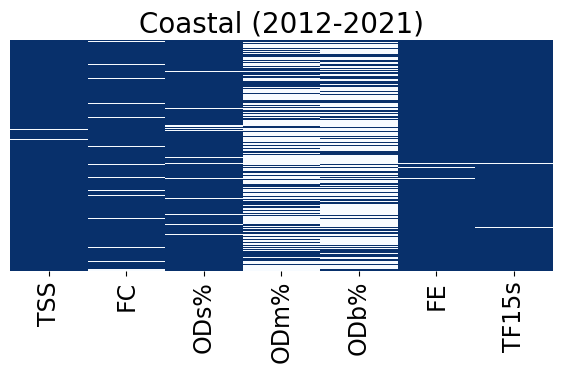

In [13]:
# Select the columns you want to include in the heatmap
selected_columns_coastal_2012_2021 = df_nm_2012_2021.columns[6:13]  # Replace with the range of column names you want

# Create a heatmap of missing values for only the selected columns
plt.figure(figsize=(7,3))  # Adjust the size of the figure

# Generates a heat map showing the presence of missing values in selected columns
heatmap = sns.heatmap(df_nm_2012_2021[selected_columns_coastal_2012_2021].isnull(), cbar=False, cmap='Blues_r')

# Rotate the x-axis labels by 90 degrees so they are vertical and increase the font size
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=17)

# Remove the y-axis ticks and labels
heatmap.set_yticks([])
heatmap.set_yticklabels([])

plt.title('Coastal (2012-2021)', loc='center', fontsize=20)
plt.xlabel('', loc='center', fontsize=20)
plt.show()

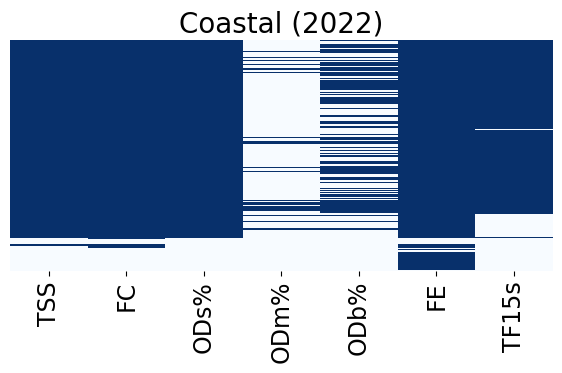

In [14]:
# Select the columns you want to include in the heatmap
selected_columns_coastal_2022 = df_nm_2022.columns[6:13]  # Replace with the range of column names you want

# Create a heatmap of missing values for only the selected columns
plt.figure(figsize=(7,3))  # Adjust the size of the figure

# Generates a heat map showing the presence of missing values in selected columns
heatmap = sns.heatmap(df_nm_2022[selected_columns_coastal_2022].isnull(), cbar=False, cmap='Blues_r')

# Rotate the x-axis labels by 90 degrees so they are vertical and increase the font size
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=17)

# Remove the y-axis ticks and labels
heatmap.set_yticks([])
heatmap.set_yticklabels([])

plt.title('Coastal (2022)', loc='center', fontsize=20)
plt.xlabel('', loc='center', fontsize=20)
plt.show()

In [ ]:
#Realizar un analisis exploratorio de los datos anteriores, como matriz de nulidad, y grafica de correlacion y otro tipo de gracicas para el analisis exploratorio

Functions for the 'quality_' and 'complies_' columns


In [ ]:
# Create a new DataFrame 'data_coastal' by assigning NaN values to columns for water quality and compliance for each contaminant
data_coastal = df_coastal.assign(quality_TSS=np.nan,quality_FC=np.nan,quality_ODs=np.nan,quality_ODm=np.nan,quality_ODb=np.nan,quality_FE=np.nan,quality_TF15s=np.nan,quality_TF15b=np.nan,
                                complies_TSS=np.nan,complies_FC=np.nan,complies_ODs=np.nan,complies_ODm=np.nan,complies_ODb=np.nan,complies_FE=np.nan,complies_TF15s=np.nan,complies_TF15b=np.nan)

In [ ]:
data_coastal.columns

Index(['CLAVE SITIO', 'CLAVE MONITOREO', 'NOMBRE DEL SITIO',
       'TIPO CUERPO DE AGUA', 'FECHA REALIZACIÓN', 'AÑO', 'TSS', 'FC', 'ODs%',
       'ODm%', 'ODb%', 'FE', 'TF15s', 'TF15b', 'quality_TSS', 'quality_FC',
       'quality_ODs', 'quality_ODm', 'quality_ODb', 'quality_FE',
       'quality_TF15s', 'quality_TF15b', 'complies_TSS', 'complies_FC',
       'complies_ODs', 'complies_ODm', 'complies_ODb', 'complies_FE',
       'complies_TF15s', 'complies_TF15b'],
      dtype='object')

In [ ]:
# Display general information about the new columns added to the data_coastal DataFrame
data_coastal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5340 entries, 0 to 23397
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLAVE SITIO          5340 non-null   object        
 1   CLAVE MONITOREO      5340 non-null   object        
 2   NOMBRE DEL SITIO     5340 non-null   object        
 3   TIPO CUERPO DE AGUA  5340 non-null   object        
 4   FECHA REALIZACIÓN    5340 non-null   datetime64[ns]
 5   AÑO                  5340 non-null   object        
 6   TSS                  5340 non-null   float64       
 7   FC                   5340 non-null   float64       
 8   ODs%                 5340 non-null   float64       
 9   ODm%                 5340 non-null   float64       
 10  ODb%                 5340 non-null   float64       
 11  FE                   5340 non-null   float64       
 12  TF15s                5340 non-null   float64       
 13  TF15b                5340 non-nu

Function for the 'quality_' column

In [ ]:
#---------------------------quality_TSS---------------------------------------------------------------------------------
col = 'TSS'
conditions  = [ data_coastal[col] <= 25, (data_coastal[col] > 25) & (data_coastal[col] <= 75), (data_coastal[col] > 75) & (data_coastal[col] <= 150), (data_coastal[col] > 150) & (data_coastal[col] <= 400), data_coastal[col] > 400 ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_coastal['quality_TSS'] = np.select(conditions, choices, default=np.nan)

#---------------------------quality_FC-------------------------------------------------------------------
col = 'FC'
conditions  = [ data_coastal[col] <= 100, (data_coastal[col] > 100) & (data_coastal[col] <= 200), (data_coastal[col] > 200) & (data_coastal[col] <= 1000), (data_coastal[col] > 1000) & (data_coastal[col] <= 10000), data_coastal[col] > 10000 ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_coastal['quality_FC'] = np.select(conditions, choices, default=np.nan)

#---------------------------quality_ODs-------------------------------------------------------------------------
col = 'ODs%'
conditions  = [ (data_coastal[col] > 70) & (data_coastal[col] <= 110),
                (((data_coastal[col] > 50) & (data_coastal[col] <= 70))|((data_coastal[col] > 110)&(data_coastal[col] <= 120))),
                (((data_coastal[col] > 30) & (data_coastal[col] <= 50))|((data_coastal[col] > 120)&(data_coastal[col] <= 130))),
                (((data_coastal[col] > 10) & (data_coastal[col] <= 30))|((data_coastal[col] > 130)&(data_coastal[col] <= 150))),
                ((data_coastal[col] <= 10)|(data_coastal[col] > 150)) ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_coastal['quality_ODs'] = np.select(conditions, choices, default=np.nan)


#---------------------------quality_ODm-------------------------------------------------------------------------
col = 'ODm%'
conditions  = [ (data_coastal[col] > 70) & (data_coastal[col] <= 110),
                (((data_coastal[col] > 50) & (data_coastal[col] <= 70))|((data_coastal[col] > 110)&(data_coastal[col] <= 120))),
                (((data_coastal[col] > 30) & (data_coastal[col] <= 50))|((data_coastal[col] > 120)&(data_coastal[col] <= 130))),
                (((data_coastal[col] > 10) & (data_coastal[col] <= 30))|((data_coastal[col] > 130)&(data_coastal[col] <= 150))),
                ((data_coastal[col] <= 10)|(data_coastal[col] > 150)) ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_coastal['quality_ODm'] = np.select(conditions, choices, default=np.nan)

#---------------------------quality_ODb-------------------------------------------------------------------------
col = 'ODb%'
conditions  = [ (data_coastal[col] > 70) & (data_coastal[col] <= 110),
                (((data_coastal[col] > 50) & (data_coastal[col] <= 70))|((data_coastal[col] > 110)&(data_coastal[col] <= 120))),
                (((data_coastal[col] > 30) & (data_coastal[col] <= 50))|((data_coastal[col] > 120)&(data_coastal[col] <= 130))),
                (((data_coastal[col] > 10) & (data_coastal[col] <= 30))|((data_coastal[col] > 130)&(data_coastal[col] <= 150))),
                ((data_coastal[col] <= 10)|(data_coastal[col] > 150)) ]
choices     = [ 'Excelente', 'Buena calidad', 'Aceptable', 'Contaminada', 'Fuertemente contaminada']
data_coastal['quality_ODb'] = np.select(conditions, choices, default=np.nan)

#---------------------------quality_FE--------------------------------------------------------------------------------
col = 'FE'
conditions  = [ data_coastal[col] <= 100, (data_coastal[col] > 100) & (data_coastal[col] <= 200), (data_coastal[col] > 200) & (data_coastal[col] <= 500), data_coastal[col] > 500 ]
choices     = [ 'Excelente', 'Buena calidad', 'Contaminada', 'Fuertemente contaminada']
data_coastal['quality_FE'] = np.select(conditions, choices, default=np.nan)

#---------------------------quality_TF15s---------------------------------------------------------------------
col = 'TF15s'
conditions  = [(data_coastal[col] < 1), (data_coastal[col] >= 1) & (data_coastal[col] <= 1.33), (data_coastal[col] > 1.33) & (data_coastal[col] < 5), data_coastal[col] >= 5 ]
choices     = [ 'No tóxico', 'Toxicidad baja', 'Toxicidad moderada', 'Toxicidad alta' ]
data_coastal['quality_TF15s'] = np.select(conditions, choices, default=np.nan)


#---------------------------quality_TF15b---------------------------------------------------------------------
col = 'TF15b'
conditions  = [(data_coastal[col] < 1), (data_coastal[col] >= 1) & (data_coastal[col] <= 1.33), (data_coastal[col] > 1.33) & (data_coastal[col] < 5), data_coastal[col] >= 5 ]
choices     = [ 'No tóxico', 'Toxicidad baja', 'Toxicidad moderada', 'Toxicidad alta' ]
data_coastal['quality_TF15b'] = np.select(conditions, choices, default=np.nan)

In [ ]:
data_coastal.iloc[:5, 14:21] #Columnas tipo de quality_

,quality_TSS,quality_FC,quality_ODs,quality_ODm,quality_ODb,quality_FE,quality_TF15s
0,Excelente,Excelente,Excelente,Excelente,Excelente,Excelente,Toxicidad baja
3,Excelente,Excelente,Excelente,Excelente,Excelente,Excelente,Toxicidad baja
4,Excelente,Excelente,Excelente,Excelente,Excelente,Excelente,Toxicidad baja
5,Excelente,Aceptable,Excelente,Excelente,Excelente,Excelente,Toxicidad baja
6,Excelente,Excelente,Excelente,Excelente,Excelente,Excelente,Toxicidad baja


Function for the 'complies_' column

In [ ]:
#---------------------------complies for quality_TSS-----------------------------------------------------
col = 'quality_TSS'
conditions  = [ data_coastal[col] == 'Excelente', data_coastal[col] == 'Buena calidad', data_coastal[col] == 'Aceptable', data_coastal[col] == 'Contaminada', data_coastal[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_coastal['complies_TSS'] = np.select(conditions, choices, default=np.nan)
data_coastal['complies_TSS'] = data_coastal['complies_TSS'].astype('int32')

#---------------------------complies for quality_FC-----------------------------------------------------
col = 'quality_FC'
conditions  = [ data_coastal[col] == 'Excelente', data_coastal[col] == 'Buena calidad', data_coastal[col] == 'Aceptable', data_coastal[col] == 'Contaminada', data_coastal[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_coastal['complies_FC'] = np.select(conditions, choices, default=np.nan)
data_coastal['complies_FC'] = data_coastal['complies_FC'].astype('int32')

#---------------------------complies for quality_ODs-----------------------------------------------------
col = 'quality_ODs'
conditions  = [ data_coastal[col] == 'Excelente', data_coastal[col] == 'Buena calidad', data_coastal[col] == 'Aceptable', data_coastal[col] == 'Contaminada', data_coastal[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_coastal['complies_ODs'] = np.select(conditions, choices, default=np.nan)
data_coastal['complies_ODs'] = data_coastal['complies_ODs'].astype('int32')

#---------------------------complies for quality_ODm-----------------------------------------------------
col = 'quality_ODm'
conditions  = [ data_coastal[col] == 'Excelente', data_coastal[col] == 'Buena calidad', data_coastal[col] == 'Aceptable', data_coastal[col] == 'Contaminada', data_coastal[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_coastal['complies_ODm'] = np.select(conditions, choices, default=np.nan)
data_coastal['complies_ODm'] = data_coastal['complies_ODm'].astype('int32')

#---------------------------complies for quality_ODb-----------------------------------------------------
col = 'quality_ODb'
conditions  = [ data_coastal[col] == 'Excelente', data_coastal[col] == 'Buena calidad', data_coastal[col] == 'Aceptable', data_coastal[col] == 'Contaminada', data_coastal[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_coastal['complies_ODb'] = np.select(conditions, choices, default=np.nan)
data_coastal['complies_ODb'] = data_coastal['complies_ODb'].astype('int32')

#---------------------------complies for quality_FE-----------------------------------------------------
col = 'quality_FE'
conditions  = [ data_coastal[col] == 'Excelente', data_coastal[col] == 'Buena calidad', data_coastal[col] == 'Contaminada', data_coastal[col] == 'Fuertemente contaminada']
choices     = [ 1, 1, 0, 0 ]
data_coastal['complies_FE'] = np.select(conditions, choices, default=np.nan)
data_coastal['complies_FE'] = data_coastal['complies_FE'].astype('int32')

#---------------------------complies for quality_TF15s-----------------------------------------------------
col = 'quality_TF15s'
conditions  = [ data_coastal[col] == 'No tóxico', data_coastal[col] == 'Toxicidad baja', data_coastal[col] == 'Toxicidad moderada', data_coastal[col] == 'Toxicidad alta']
choices     = [ 1, 1, 1, 0 ]
data_coastal['complies_TF15s'] = np.select(conditions, choices, default=np.nan)
data_coastal['complies_TF15s'] = data_coastal['complies_TF15s'].astype('int32')

#---------------------------complies for quality_TF15b-----------------------------------------------------
col = 'quality_TF15b'
conditions  = [ data_coastal[col] == 'No tóxico', data_coastal[col] == 'Toxicidad baja', data_coastal[col] == 'Toxicidad moderada', data_coastal[col] == 'Toxicidad alta']
choices     = [ 1, 1, 1, 0 ]
data_coastal['complies_TF15b'] = np.select(conditions, choices, default=np.nan)
data_coastal['complies_TF15b'] = data_coastal['complies_TF15b'].astype('int32')

In [ ]:
data_coastal.iloc[:5, 22:]

,complies_TSS,complies_FC,complies_ODs,complies_ODm,complies_ODb,complies_FE,complies_TF15s,complies_TF15b
0,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1


Assignment of water quality

In [ ]:
conditions  = [(data_coastal['complies_TF15s'] == 0) | (data_coastal['complies_TF15b'] == 0) | (data_coastal['complies_FE'] == 0),
               (data_coastal['complies_FC'] == 0) | (data_coastal['complies_TSS'] == 0) | (data_coastal['complies_ODs'] == 0) | (data_coastal['complies_ODm'] == 0) | (data_coastal['complies_ODb'] == 0),
               (data_coastal['complies_FC'] == 1) & (data_coastal['complies_TF15s'] == 1) & (data_coastal['complies_TF15b'] == 1) & (data_coastal['complies_ODs'] == 1) & (data_coastal['complies_ODm'] == 1) & (data_coastal['complies_ODb'] == 1) & (data_coastal['complies_FE'] == 1) & (data_coastal['complies_TSS'] == 1)]
choices     = [2, 1, 0]
data_coastal['Water quality'] = np.select(conditions, choices, default=np.nan)
data_coastal['Water quality'] = data_coastal['Water quality'].astype('int32')

In [ ]:
# Creates a new DataFrame for model training from the years 2012 to 2021, excluding data for the year 2022
df_train_coastal = data_coastal[data_coastal['AÑO'] != 2022]

# Creates a new DataFrame for validation consisting only of data from the year 2022
df_val_coastal = data_coastal[data_coastal['AÑO'] == 2022]

In [ ]:
# Displays the size of the training DataFrame
df_train_coastal.shape

(5319, 31)

In [ ]:
# Displays the size of the validation DataFrame
df_val_coastal.shape

(21, 31)

In [ ]:
# Selects columns for model training including contaminant columns and the target variable 'Water quality' for the dataset from 2012 to 2021
df_train_coastal = df_train_coastal.iloc[:, list(range(6, 14)) + [30]]
df_train_coastal.head(5)

,TSS,FC,ODs%,ODm%,ODb%,FE,TF15s,TF15b,Water quality
0,10.00,3.0,90.1,89.50,95.1,10.0,1.0,1.0,0
3,10.25,75.0,103.7,100.20,100.2,1.0,1.0,1.0,0
4,10.00,1.0,89.5,92.01,93.0,1.0,1.0,1.0,0
5,21.25,265.0,105.8,105.90,105.8,10.0,1.0,1.0,0
6,13.00,41.0,109.3,107.20,105.1,1.0,1.0,1.0,0


In [ ]:
# Selects columns for model training including contaminant columns and the target variable 'Water quality' for the dataset of 2022
df_val_coastal = df_val_coastal.iloc[:, list(range(6, 14)) + [30]]
df_val_coastal.head(5)

,TSS,FC,ODs%,ODm%,ODb%,FE,TF15s,TF15b,Water quality
23245,10.0,1500.0,74.1,56.8,34.8,10.0,1.0,1.0,1
23250,40.2,63.0,83.4,72.7,65.0,10.0,1.0,1.0,0
23253,34.4,393.0,78.7,66.9,56.7,10.0,1.0,1.0,0
23257,40.0,295.0,74.4,65.5,57.2,10.0,1.0,1.0,0
23261,22.3,279.0,85.4,78.6,65.1,10.0,1.0,1.0,0


Separation of the dependent variable (y) from the independent variables (X)

In [ ]:
# Separates features (X_train_coastal) and target variable (y_train_coastal) for model training
X_train_coastal = df_train_coastal.drop(columns=['Water quality'])
y_train_coastal = df_train_coastal['Water quality']

In [ ]:
# Separates features (X_val_coastal) and target variable (y_val_coastal) for validation
X_val_coastal = df_val_coastal.drop(columns=['Water quality'])
y_val_coastal = df_val_coastal['Water quality']

In [ ]:
# Calculate the count of classes present in the 'Water quality' column
conteo_clases = df_train_coastal['Water quality'].value_counts()
print(conteo_clases)

0    3882
1    1003
2     434
Name: Water quality, dtype: int64


##Unbalanced

###XGBOOST

Split data into training and test set

In [ ]:
# Split the data into training and testing sets for XGBoost model training
X_train_ub_coa_xgb, X_test_ub_coa_xgb, y_train_ub_coa_xgb, y_test_ub_coa_xgb = train_test_split(X_train_coastal, y_train_coastal, test_size=0.2, random_state=42)

Feature Standardization for Coastal Dataset using StandardScaler

In [ ]:
# Create a StandardScaler object
scaler_ub_coa_xgb = StandardScaler()

# Fit and transform the training data to standardize features
X_train_ub_coa_xgb = scaler_ub_coa_xgb.fit_transform(X_train_ub_coa_xgb)

# Transform the test data using the same scaler to maintain consistency in feature scaling
X_test_ub_coa_xgb = scaler_ub_coa_xgb.transform(X_test_ub_coa_xgb)

Hyperparameter Grid for XGBoost Model

In [ ]:
# Define a dictionary of hyperparameters for tuning a XGBoost model
parameters = {
    'learning_rate': [.01, 0.1, 0.2],
    'max_depth': [10, 30, 50],
    'n_estimators': [100, 200, 300]
}

Create a Decision XGBoost model

In [ ]:
# Initialize XGBoost classifier for coastal model
model_ub_coa_xgb = XGBClassifier()

Hyperparameter Tuning with Cross-Validation

In [ ]:
# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Create a GridSearchCV object for hyperparameter tuning
grid_search_ub_coa_xgb = GridSearchCV(model_ub_coa_xgb, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to find the best hyperparameters
grid_search_ub_coa_xgb.fit(X_train_ub_coa_xgb, y_train_ub_coa_xgb)

Wait a moment...


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [10, 30, 50],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

Best Estimator and Hyperparameters

In [ ]:
# Print the best estimator found during hyperparameter search
print("Best estimator found:")
best_model_ub_coa_xgb = grid_search_ub_coa_xgb.best_estimator_
print(best_model_ub_coa_xgb)

# Print the best hyperparameters found during hyperparameter search
print("\nBest hyperparameters found:")
best_params_ub_coa_xgb = grid_search_ub_coa_xgb.best_params_
print(best_params_ub_coa_xgb)

# Print the score of the best model in coastal_no_balancing cross-validation
print("\nScore of the best model in coastal_no_balancing cross-validation:")
best_score_ub_coa_xgb = grid_search_ub_coa_xgb.best_score_
print(best_score_ub_coa_xgb)

Best estimator found:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Best hyperparameters found:
{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}

Score of the best model in coastal_no_balancing cross-validation:
0.9938895417156287


 Evaluate the model on the training set

In [ ]:
# Make predictions on the training set
y_pred_train_ub_coa_xgb = best_model_ub_coa_xgb.predict(X_train_ub_coa_xgb)

# Evaluation metrics on the training set
accuracy_train_ub_coa_xgb = accuracy_score(y_train_ub_coa_xgb, y_pred_train_ub_coa_xgb)
precision_train_ub_coa_xgb = precision_score(y_train_ub_coa_xgb, y_pred_train_ub_coa_xgb, average='weighted')
# Calculate precision for each class
precision_x_class_train_ub_coa_xgb = precision_score(y_train_ub_coa_xgb, y_pred_train_ub_coa_xgb, average=None)
recall_train_ub_coa_xgb = recall_score(y_train_ub_coa_xgb, y_pred_train_ub_coa_xgb, average='weighted')
# Calculate recall for each class
recall_x_class_train_ub_coa_xgb = recall_score(y_train_ub_coa_xgb, y_pred_train_ub_coa_xgb, average=None)
f1_score_train_ub_coa_xgb = f1_score(y_train_ub_coa_xgb, y_pred_train_ub_coa_xgb, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_train_ub_coa_xgb = f1_score(y_train_ub_coa_xgb, y_pred_train_ub_coa_xgb, average=None)
jaccard_train_ub_coa_xgb = jaccard_score(y_train_ub_coa_xgb, y_pred_train_ub_coa_xgb, average='weighted')
confusion_train_ub_coa_xgb = confusion_matrix(y_train_ub_coa_xgb, y_pred_train_ub_coa_xgb)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy_train_ub_coa_xgb)
print("Precision: ", precision_train_ub_coa_xgb)
print("Precision per class:" , precision_x_class_train_ub_coa_xgb )
print("Recall: ", recall_train_ub_coa_xgb)
print("Recall per class:" , recall_x_class_train_ub_coa_xgb )
print("F1 Score: ", f1_score_train_ub_coa_xgb)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_train_ub_coa_xgb):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_train_ub_coa_xgb )
print("Confusion Matrix: ")
print(confusion_train_ub_coa_xgb)

Accuracy:  0.9988249118683902
Precision:  0.9988265143511595
Precision per class: [0.99935588 0.99626866 1.        ]
Recall:  0.9988249118683902
Recall per class: [0.99903413 0.99875312 0.99711816]
F1 Score:  0.9988252330546723
F1-score for the class 0: 0.999194976654323
F1-score for the class 1: 0.9975093399750935
F1-score for the class 2: 0.9985569985569985
jaccard: 0.9976540832750918
Confusion Matrix: 
[[3103    3    0]
 [   1  801    0]
 [   1    0  346]]


 Evaluate the model on the test set

In [ ]:
# Make predictions on the testing set
y_pred_test_ub_coa_xgb = best_model_ub_coa_xgb.predict(X_test_ub_coa_xgb)

# Evaluation metrics on the testing set
accuracy_test_ub_coa_xgb = accuracy_score(y_test_ub_coa_xgb, y_pred_test_ub_coa_xgb)
precision_test_ub_coa_xgb = precision_score(y_test_ub_coa_xgb, y_pred_test_ub_coa_xgb, average='weighted')
# Calculate precision for each class
precision_x_class_test_ub_coa_xgb = precision_score(y_test_ub_coa_xgb, y_pred_test_ub_coa_xgb, average=None)
recall_test_ub_coa_xgb = recall_score(y_test_ub_coa_xgb, y_pred_test_ub_coa_xgb, average='weighted')
# Calculate recall for each class
recall_x_class_test_ub_coa_xgb = recall_score(y_test_ub_coa_xgb, y_pred_test_ub_coa_xgb, average=None)
f1_score_test_ub_coa_xgb = f1_score(y_test_ub_coa_xgb, y_pred_test_ub_coa_xgb, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_test_ub_coa_xgb = f1_score(y_test_ub_coa_xgb, y_pred_test_ub_coa_xgb, average=None)
jaccard_test_ub_coa_xgb = jaccard_score(y_test_ub_coa_xgb, y_pred_test_ub_coa_xgb, average='weighted')
confusion_test_ub_coa_xgb = confusion_matrix(y_test_ub_coa_xgb, y_pred_test_ub_coa_xgb)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy_test_ub_coa_xgb)
print("Precision: ", precision_test_ub_coa_xgb)
print("Precision per class:" , precision_x_class_test_ub_coa_xgb )
print("Recall: ", recall_test_ub_coa_xgb)
print("Recall per class:" , recall_x_class_test_ub_coa_xgb )
print("F1 Score: ", f1_score_test_ub_coa_xgb)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_test_ub_coa_xgb):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_test_ub_coa_xgb )
print("Confusion Matrix: ")
print(confusion_test_ub_coa_xgb)

Accuracy:  0.9971804511278195
Precision:  0.9971781710550508
Precision per class: [0.997426 0.995    1.      ]
Recall:  0.9971804511278195
Recall per class: [0.99871134 0.99004975 1.        ]
F1 Score:  0.9971778432557574
F1-score for the class 0: 0.9980682549903412
F1-score for the class 1: 0.9925187032418954
F1-score for the class 2: 1.0
jaccard: 0.9943821086159873
Confusion Matrix: 
[[775   1   0]
 [  2 199   0]
 [  0   0  87]]


 Evaluate the model on the validation set

In [ ]:
# Transform the validation data using the scaler trained on the validation data
X_val_ub_coa_xgb = scaler_ub_coa_xgb.transform(X_val_coastal)

# Make predictions on the validation set using the trained xgboost model
y_pred_val_ub_coa_xgb = best_model_ub_coa_xgb.predict(X_val_ub_coa_xgb)

# Evaluation metrics on the validation set
accuracy_val_ub_coa_xgb = accuracy_score(y_val_coastal, y_pred_val_ub_coa_xgb)
precision_val_ub_coa_xgb = precision_score(y_val_coastal, y_pred_val_ub_coa_xgb, average='weighted')
# Calculate precision for each class
precision_x_class_val_ub_coa_xgb = precision_score(y_val_coastal, y_pred_val_ub_coa_xgb, average=None)
recall_val_ub_coa_xgb = recall_score(y_val_coastal, y_pred_val_ub_coa_xgb, average='weighted')
# Calculate recall for each class
recall_x_class_val_ub_coa_xgb = recall_score(y_val_coastal, y_pred_val_ub_coa_xgb, average=None)
f1_score_val_ub_coa_xgb = f1_score(y_val_coastal, y_pred_val_ub_coa_xgb, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_val_ub_coa_xgb = f1_score(y_val_coastal, y_pred_val_ub_coa_xgb, average=None)
jaccard_val_ub_coa_xgb = jaccard_score(y_val_coastal, y_pred_val_ub_coa_xgb, average='weighted')
confusion_val_ub_coa_xgb = confusion_matrix(y_val_coastal, y_pred_val_ub_coa_xgb)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy_val_ub_coa_xgb)
print("Precision: ", precision_val_ub_coa_xgb)
print("Precision per class:" , precision_x_class_val_ub_coa_xgb )
print("Recall: ", recall_val_ub_coa_xgb)
print("Recall per class:" , recall_x_class_val_ub_coa_xgb )
print("F1 Score: ", f1_score_val_ub_coa_xgb)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_val_ub_coa_xgb):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_val_ub_coa_xgb )
print("Confusion Matrix: ")
print(confusion_val_ub_coa_xgb)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


In [ ]:
# Save the trained XGBoost model to a file
with open('best_model_ub_coa_xgb.pkl', 'wb') as model_file:
    pickle.dump(best_model_ub_coa_xgb, model_file)

# Save the scaler used for preprocessing to a file
with open('scaler_ub_coa_xgb.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_ub_coa_xgb, scaler_file)

###SVM

Split data into training and test set

In [ ]:
X_train_ub_coa_svm, X_test_ub_coa_svm, y_train_ub_coa_svm, y_test_ub_coa_svm = train_test_split(X_train_coastal, y_train_coastal, test_size=0.2, random_state=42)

Feature Standardization for Coastal Dataset using StandardScaler

In [ ]:
# Create a StandardScaler object
scaler_ub_coa_svm = StandardScaler()

# Fit and transform the training data to standardize features
X_train_ub_coa_svm = scaler_ub_coa_svm.fit_transform(X_train_ub_coa_svm)

# Transform the test data using the same scaler to maintain consistency in feature scaling
X_test_ub_coa_svm = scaler_ub_coa_svm.transform(X_test_ub_coa_svm)

Hyperparameter Grid for SVM Model

In [ ]:
# Define a dictionary of hyperparameters for tuning a SVM model
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

Create a Decision SVM model

In [ ]:
#Create a Decision SVM model
model_ub_coa_svm = SVC()

Hyperparameter Tuning with Cross-Validation

In [ ]:
# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Create a GridSearchCV object for hyperparameter tuning
grid_search_ub_coa_svm = GridSearchCV(model_ub_coa_svm, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to find the best hyperparameters
grid_search_ub_coa_svm.fit(X_train_ub_coa_svm, y_train_ub_coa_svm)

Wait a moment...


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

Best Estimator and Hyperparameters

In [ ]:
# Print the best estimator found during hyperparameter search
print("Best estimator found:")
best_model_ub_coa_svm = grid_search_ub_coa_svm.best_estimator_
print(best_model_ub_coa_svm)

# Print the best hyperparameters found during hyperparameter search
print("\nBest hyperparameters found:")
best_params_ub_coa_svm = grid_search_ub_coa_svm.best_params_
print(best_params_ub_coa_svm)

# Print the score of the best model in coastal_no_balancing cross-validation
print("\nScore of the best model in coastal_no_balancing cross-validation:")
best_score_ub_coa_svm = grid_search_ub_coa_svm.best_score_
print(best_score_ub_coa_svm)

Best estimator found:
SVC(C=10, gamma='auto')

Best hyperparameters found:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Score of the best model in coastal_no_balancing cross-validation:
0.9623971797884842


 Evaluate the model on the training set

In [ ]:
# Make predictions on the training set
y_pred_train_ub_coa_svm = best_model_ub_coa_svm.predict(X_train_ub_coa_svm)

# Evaluation metrics on the training set
accuracy_train_ub_coa_svm = accuracy_score(y_train_ub_coa_svm, y_pred_train_ub_coa_svm)
precision_train_ub_coa_svm = precision_score(y_train_ub_coa_svm, y_pred_train_ub_coa_svm, average='weighted')
# Calculate precision for each class
precision_x_class_train_ub_coa_svm = precision_score(y_train_ub_coa_svm, y_pred_train_ub_coa_svm, average=None)
recall_train_ub_coa_svm = recall_score(y_train_ub_coa_svm, y_pred_train_ub_coa_svm, average='weighted')
# Calculate recall for each class
recall_x_class_train_ub_coa_svm = recall_score(y_train_ub_coa_svm, y_pred_train_ub_coa_svm, average=None)
f1_score_train_ub_coa_svm = f1_score(y_train_ub_coa_svm, y_pred_train_ub_coa_svm, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_train_ub_coa_svm = f1_score(y_train_ub_coa_svm, y_pred_train_ub_coa_svm, average=None)
jaccard_train_ub_coa_svm = jaccard_score(y_train_ub_coa_svm, y_pred_train_ub_coa_svm, average='weighted')
confusion_train_ub_coa_svm = confusion_matrix(y_train_ub_coa_svm, y_pred_train_ub_coa_svm)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy_train_ub_coa_svm)
print("Precision: ", precision_train_ub_coa_svm)
print("Precision per class:" , precision_x_class_train_ub_coa_svm )
print("Recall: ", recall_train_ub_coa_svm)
print("Recall per class:" , recall_x_class_train_ub_coa_svm )
print("F1 Score: ", f1_score_train_ub_coa_svm)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_train_ub_coa_svm):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_train_ub_coa_svm )
print("Confusion Matrix: ")
print(confusion_train_ub_coa_svm)

Accuracy:  0.9699177438307873
Precision:  0.9703700778146039
Precision per class: [0.97382529 0.94416873 1.        ]
Recall:  0.9699177438307873
Recall per class: [0.99420476 0.94887781 0.80115274]
F1 Score:  0.9691706477249029
F1-score for the class 0: 0.9839095109128565
F1-score for the class 1: 0.9465174129353233
F1-score for the class 2: 0.8896000000000001
jaccard: 0.9415270954251913
Confusion Matrix: 
[[3088   18    0]
 [  41  761    0]
 [  42   27  278]]


 Evaluate the model on the test set

In [ ]:
# Make predictions on the testing set
y_pred_test_ub_coa_svm = best_model_ub_coa_svm.predict(X_test_ub_coa_svm)

# Evaluation metrics on the testing set
accuracy_test_ub_coa_svm = accuracy_score(y_test_ub_coa_svm, y_pred_test_ub_coa_svm)
precision_test_ub_coa_svm = precision_score(y_test_ub_coa_svm, y_pred_test_ub_coa_svm, average='weighted')
# Calculate precision for each class
precision_x_class_test_ub_coa_svm = precision_score(y_test_ub_coa_svm, y_pred_test_ub_coa_svm, average=None)
recall_test_ub_coa_svm = recall_score(y_test_ub_coa_svm, y_pred_test_ub_coa_svm, average='weighted')
# Calculate recall for each class
recall_x_class_test_ub_coa_svm = recall_score(y_test_ub_coa_svm, y_pred_test_ub_coa_svm, average=None)
f1_score_test_ub_coa_svm = f1_score(y_test_ub_coa_svm, y_pred_test_ub_coa_svm, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_test_ub_coa_svm = f1_score(y_test_ub_coa_svm, y_pred_test_ub_coa_svm, average=None)
jaccard_test_ub_coa_svm = jaccard_score(y_test_ub_coa_svm, y_pred_test_ub_coa_svm, average='weighted')
confusion_test_ub_coa_svm = confusion_matrix(y_test_ub_coa_svm, y_pred_test_ub_coa_svm)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy_test_ub_coa_svm)
print("Precision: ", precision_test_ub_coa_svm)
print("Precision per class:" , precision_x_class_test_ub_coa_svm )
print("Recall: ", recall_test_ub_coa_svm)
print("Recall per class:" , recall_x_class_test_ub_coa_svm )
print("F1 Score: ", f1_score_test_ub_coa_svm)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_test_ub_coa_svm):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_test_ub_coa_svm )
print("Confusion Matrix: ")
print(confusion_test_ub_coa_svm)

Accuracy:  0.9624060150375939
Precision:  0.9631150149807105
Precision per class: [0.96737767 0.93069307 1.        ]
Recall:  0.9624060150375939
Recall per class: [0.9935567  0.93532338 0.74712644]
F1 Score:  0.9611356418518322
F1-score for the class 0: 0.9802924348378894
F1-score for the class 1: 0.9330024813895781
F1-score for the class 2: 0.8552631578947367
jaccard: 0.927408954009451
Confusion Matrix: 
[[771   5   0]
 [ 13 188   0]
 [ 13   9  65]]


 Evaluate the model on the validation set

In [ ]:
# Transform the validation data using the scaler trained on the validation data
X_val_ub_coa_svm = scaler_ub_coa_svm.transform(X_val_coastal)

# Make predictions on the validation set using the trained svm model
y_pred_val_ub_coa_svm = best_model_ub_coa_svm.predict(X_val_ub_coa_svm)

# Evaluation metrics on the validation set
accuracy_val_ub_coa_svm = accuracy_score(y_val_coastal, y_pred_val_ub_coa_svm)
precision_val_ub_coa_svm = precision_score(y_val_coastal, y_pred_val_ub_coa_svm, average='weighted')
# Calculate precision for each class
precision_x_class_val_ub_coa_svm = precision_score(y_val_coastal, y_pred_val_ub_coa_svm, average=None)
recall_val_ub_coa_svm = recall_score(y_val_coastal, y_pred_val_ub_coa_svm, average='weighted')
# Calculate recall for each class
recall_x_class_val_ub_coa_svm = recall_score(y_val_coastal, y_pred_val_ub_coa_svm, average=None)
f1_score_val_ub_coa_svm = f1_score(y_val_coastal, y_pred_val_ub_coa_svm, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_val_ub_coa_svm = f1_score(y_val_coastal, y_pred_val_ub_coa_svm, average=None)
jaccard_val_ub_coa_svm = jaccard_score(y_val_coastal, y_pred_val_ub_coa_svm, average='weighted')
confusion_val_ub_coa_svm = confusion_matrix(y_val_coastal, y_pred_val_ub_coa_svm)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy_val_ub_coa_svm)
print("Precision: ", precision_val_ub_coa_svm)
print("Precision per class:" , precision_x_class_val_ub_coa_svm )
print("Recall: ", recall_val_ub_coa_svm)
print("Recall per class:" , recall_x_class_val_ub_coa_svm )
print("F1 Score: ", f1_score_val_ub_coa_svm)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_val_ub_coa_svm):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_val_ub_coa_svm )
print("Confusion Matrix: ")
print(confusion_val_ub_coa_svm)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


In [ ]:
# Save the trained SVM model to a file
with open('best_model_ub_coa_svm.pkl', 'wb') as model_file:
    pickle.dump(best_model_ub_coa_svm, model_file)

# Save the scaler used for preprocessing to a file
with open('scaler_ub_coa_svm.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_ub_coa_svm, scaler_file)

###KNN

Split data into training and test set

In [ ]:
X_train_ub_coa_knn, X_test_ub_coa_knn, y_train_ub_coa_knn, y_test_ub_coa_knn = train_test_split(X_train_coastal, y_train_coastal, test_size=0.2, random_state=42)

Feature Standardization for Coastal Dataset using StandardScaler

In [ ]:
# Create a StandardScaler object
scaler_ub_coa_knn = StandardScaler()

# Fit and transform the training data to standardize features
X_train_ub_coa_knn = scaler_ub_coa_knn.fit_transform(X_train_ub_coa_knn)

# Transform the test data using the same scaler to maintain consistency in feature scaling
X_test_ub_coa_knn = scaler_ub_coa_knn.transform(X_test_ub_coa_knn)

Hyperparameter Grid for KNN Model

In [ ]:
# Define a dictionary of hyperparameters for tuning a KNN model
parameters = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de ponderación
    'p': [1, 2]  # Parámetro para la distancia (1 para la distancia de Manhattan, 2 para la Euclidiana)
}

Create a Decision KNN model

In [ ]:
model_ub_coa_knn = KNeighborsClassifier()

Hyperparameter Tuning with Cross-Validation

In [ ]:
# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Create a GridSearchCV object for hyperparameter tuning
grid_search_ub_coa_knn = GridSearchCV(model_ub_coa_knn, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to find the best hyperparameters
grid_search_ub_coa_knn.fit(X_train_ub_coa_knn, y_train_ub_coa_knn)

Wait a moment...


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Best Estimator and Hyperparameters

In [ ]:
# Print the best estimator found during hyperparameter search
print("Best estimator found:")
best_model_ub_coa_knn = grid_search_ub_coa_knn.best_estimator_
print(best_model_ub_coa_knn)

# Print the best hyperparameters found during hyperparameter search
print("\nBest hyperparameters found:")
best_params_ub_coa_knn = grid_search_ub_coa_knn.best_params_
print(best_params_ub_coa_knn)

# Print the score of the best model in coastal_no_balancing cross-validation
print("\nScore of the best model in coastal_no_balancing cross-validation:")
best_score_ub_coa_knn = grid_search_ub_coa_knn.best_score_
print(best_score_ub_coa_knn)

Best estimator found:
KNeighborsClassifier(n_neighbors=3, weights='distance')

Best hyperparameters found:
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

Score of the best model in coastal_no_balancing cross-validation:
0.9381903642773206


 Evaluate the model on the training set

In [ ]:
# Make predictions on the training set
y_pred_train_ub_coa_knn = best_model_ub_coa_knn.predict(X_train_ub_coa_knn)

# Evaluation metrics on the training set
accuracy_train_ub_coa_knn = accuracy_score(y_train_ub_coa_knn, y_pred_train_ub_coa_knn)
precision_train_ub_coa_knn = precision_score(y_train_ub_coa_knn, y_pred_train_ub_coa_knn, average='weighted')
# Calculate precision for each class
precision_x_class_train_ub_coa_knn = precision_score(y_train_ub_coa_knn, y_pred_train_ub_coa_knn, average=None)
recall_train_ub_coa_knn = recall_score(y_train_ub_coa_knn, y_pred_train_ub_coa_knn, average='weighted')
# Calculate recall for each class
recall_x_class_train_ub_coa_knn = recall_score(y_train_ub_coa_knn, y_pred_train_ub_coa_knn, average=None)
f1_score_train_ub_coa_knn = f1_score(y_train_ub_coa_knn, y_pred_train_ub_coa_knn, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_train_ub_coa_knn = f1_score(y_train_ub_coa_knn, y_pred_train_ub_coa_knn, average=None)
jaccard_train_ub_coa_knn = jaccard_score(y_train_ub_coa_knn, y_pred_train_ub_coa_knn, average='weighted')
confusion_train_ub_coa_knn = confusion_matrix(y_train_ub_coa_knn, y_pred_train_ub_coa_knn)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy_train_ub_coa_knn)
print("Precision: ", precision_train_ub_coa_knn)
print("Precision per class:" , precision_x_class_train_ub_coa_knn )
print("Recall: ", recall_train_ub_coa_knn)
print("Recall per class:" , recall_x_class_train_ub_coa_knn )
print("F1 Score: ", f1_score_train_ub_coa_knn)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_train_ub_coa_knn):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_train_ub_coa_knn )
print("Confusion Matrix: ")
print(confusion_train_ub_coa_knn)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[3106    0    0]
 [   0  802    0]
 [   0    0  347]]


 Evaluate the model on the test set

In [ ]:
# Make predictions on the testing set
y_pred_test_ub_coa_knn = best_model_ub_coa_knn.predict(X_test_ub_coa_knn)

# Evaluation metrics on the testing set
accuracy_test_ub_coa_knn = accuracy_score(y_test_ub_coa_knn, y_pred_test_ub_coa_knn)
precision_test_ub_coa_knn = precision_score(y_test_ub_coa_knn, y_pred_test_ub_coa_knn, average='weighted')
# Calculate precision for each class
precision_x_class_test_ub_coa_knn = precision_score(y_test_ub_coa_knn, y_pred_test_ub_coa_knn, average=None)
recall_test_ub_coa_knn = recall_score(y_test_ub_coa_knn, y_pred_test_ub_coa_knn, average='weighted')
# Calculate recall for each class
recall_x_class_test_ub_coa_knn = recall_score(y_test_ub_coa_knn, y_pred_test_ub_coa_knn, average=None)
f1_score_test_ub_coa_knn = f1_score(y_test_ub_coa_knn, y_pred_test_ub_coa_knn, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_test_ub_coa_knn = f1_score(y_test_ub_coa_knn, y_pred_test_ub_coa_knn, average=None)
jaccard_test_ub_coa_knn = jaccard_score(y_test_ub_coa_knn, y_pred_test_ub_coa_knn, average='weighted')
confusion_test_ub_coa_knn = confusion_matrix(y_test_ub_coa_knn, y_pred_test_ub_coa_knn)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy_test_ub_coa_knn)
print("Precision: ", precision_test_ub_coa_knn)
print("Precision per class:" , precision_x_class_test_ub_coa_knn )
print("Recall: ", recall_test_ub_coa_knn)
print("Recall per class:" , recall_x_class_test_ub_coa_knn )
print("F1 Score: ", f1_score_test_ub_coa_knn)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_test_ub_coa_knn):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_test_ub_coa_knn )
print("Confusion Matrix: ")
print(confusion_test_ub_coa_knn)

Accuracy:  0.9351503759398496
Precision:  0.9370840363768624
Precision per class: [0.95380774 0.85377358 0.98039216]
Recall:  0.9351503759398496
Recall per class: [0.98453608 0.90049751 0.57471264]
F1 Score:  0.9314953484063278
F1-score for the class 0: 0.9689283449587824
F1-score for the class 1: 0.8765133171912833
F1-score for the class 2: 0.7246376811594203
jaccard: 0.8792072233593562
Confusion Matrix: 
[[764  11   1]
 [ 20 181   0]
 [ 17  20  50]]


 Evaluate the model on the validation set

In [ ]:
# Transform the validation data using the scaler trained on the validation data
X_val_ub_coa_knn = scaler_ub_coa_knn.transform(X_val_coastal)

# Make predictions on the validation set using the trained knn model
y_pred_val_ub_coa_knn = best_model_ub_coa_knn.predict(X_val_ub_coa_knn)

# Evaluation metrics on the validation set
accuracy_val_ub_coa_knn = accuracy_score(y_val_coastal, y_pred_val_ub_coa_knn)
precision_val_ub_coa_knn = precision_score(y_val_coastal, y_pred_val_ub_coa_knn, average='weighted')
# Calculate precision for each class
precision_x_class_val_ub_coa_knn = precision_score(y_val_coastal, y_pred_val_ub_coa_knn, average=None)
recall_val_ub_coa_knn = recall_score(y_val_coastal, y_pred_val_ub_coa_knn, average='weighted')
# Calculate recall for each class
recall_x_class_val_ub_coa_knn = recall_score(y_val_coastal, y_pred_val_ub_coa_knn, average=None)
f1_score_val_ub_coa_knn = f1_score(y_val_coastal, y_pred_val_ub_coa_knn, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_val_ub_coa_knn = f1_score(y_val_coastal, y_pred_val_ub_coa_knn, average=None)
jaccard_val_ub_coa_knn = jaccard_score(y_val_coastal, y_pred_val_ub_coa_knn, average='weighted')
confusion_val_ub_coa_knn = confusion_matrix(y_val_coastal, y_pred_val_ub_coa_knn)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy_val_ub_coa_knn)
print("Precision: ", precision_val_ub_coa_knn)
print("Precision per class:" , precision_x_class_val_ub_coa_knn )
print("Recall: ", recall_val_ub_coa_knn)
print("Recall per class:" , recall_x_class_val_ub_coa_knn )
print("F1 Score: ", f1_score_val_ub_coa_knn)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_val_ub_coa_knn):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_val_ub_coa_knn )
print("Confusion Matrix: ")
print(confusion_val_ub_coa_knn)

Accuracy:  0.9047619047619048
Precision:  0.9551820728291316
Precision per class: [0.94117647 1.         0.        ]
Recall:  0.9047619047619048
Recall per class: [1.  0.6 0. ]
F1 Score:  0.9173881673881674
F1-score for the class 0: 0.9696969696969697
F1-score for the class 1: 0.7499999999999999
F1-score for the class 2: 0.0
jaccard: 0.8599439775910364
Confusion Matrix: 
[[16  0  0]
 [ 1  3  1]
 [ 0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Save the trained KNN model to a file
with open('best_model_ub_coa_knn.pkl', 'wb') as model_file:
    pickle.dump(best_model_ub_coa_knn, model_file)

# Save the scaler used for preprocessing to a file
with open('scaler_ub_coa_knn.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_ub_coa_knn, scaler_file)

###DT

Split data into training and test set

In [ ]:
X_train_ub_coa_dt, X_test_ub_coa_dt, y_train_ub_coa_dt, y_test_ub_coa_dt = train_test_split(X_train_coastal, y_train_coastal, test_size=0.2, random_state=42)

Feature Standardization for Coastal Dataset using StandardScaler

In [ ]:
# Create a StandardScaler object
scaler_ub_coa_dt = StandardScaler()

# Fit and transform the training data to standardize features
X_train_ub_coa_dt = scaler_ub_coa_dt.fit_transform(X_train_ub_coa_dt)

# Transform the test data using the same scaler to maintain consistency in feature scaling
X_test_ub_coa_dt = scaler_ub_coa_dt.transform(X_test_ub_coa_dt)

Hyperparameter Grid for DT Model

In [ ]:
# Define a dictionary of hyperparameters for tuning a DT model
parameters = {
    'criterion': ['gini', 'entropy'],  # Criterio para la división de nodos
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en una hoja
}

Create a Decision DT model

In [ ]:
model_ub_coa_dt = DecisionTreeClassifier()

Hyperparameter Tuning with Cross-Validation

In [ ]:
# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Create a GridSearchCV object for hyperparameter tuning
grid_search_ub_coa_dt = GridSearchCV(model_ub_coa_dt, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to find the best hyperparameters
grid_search_ub_coa_dt.fit(X_train_ub_coa_dt, y_train_ub_coa_dt)

Wait a moment...


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

Best Estimator and Hyperparameters

In [ ]:
# Print the best estimator found during hyperparameter search
print("Best estimator found:")
best_model_ub_coa_dt = grid_search_ub_coa_dt.best_estimator_
print(best_model_ub_coa_dt)

# Print the best hyperparameters found during hyperparameter search
print("\nBest hyperparameters found:")
best_params_ub_coa_dt = grid_search_ub_coa_dt.best_params_
print(best_params_ub_coa_dt)

# Print the score of the best model in coastal_no_balancing cross-validation
print("\nScore of the best model in coastal_no_balancing cross-validation:")
best_score_ub_coa_dt = grid_search_ub_coa_dt.best_score_
print(best_score_ub_coa_dt)

Best estimator found:
DecisionTreeClassifier(criterion='entropy', min_samples_split=10)

Best hyperparameters found:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

Score of the best model in coastal_no_balancing cross-validation:
0.9981198589894242


 Evaluate the model on the training set

In [ ]:
# Make predictions on the training set
y_pred_train_ub_coa_dt = best_model_ub_coa_dt.predict(X_train_ub_coa_dt)

# Evaluation metrics on the training set
accuracy_train_ub_coa_dt = accuracy_score(y_train_ub_coa_dt, y_pred_train_ub_coa_dt)
precision_train_ub_coa_dt = precision_score(y_train_ub_coa_dt, y_pred_train_ub_coa_dt, average='weighted')
# Calculate precision for each class
precision_x_class_train_ub_coa_dt = precision_score(y_train_ub_coa_dt, y_pred_train_ub_coa_dt, average=None)
recall_train_ub_coa_dt = recall_score(y_train_ub_coa_dt, y_pred_train_ub_coa_dt, average='weighted')
# Calculate recall for each class
recall_x_class_train_ub_coa_dt = recall_score(y_train_ub_coa_dt, y_pred_train_ub_coa_dt, average=None)
f1_score_train_ub_coa_dt = f1_score(y_train_ub_coa_dt, y_pred_train_ub_coa_dt, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_train_ub_coa_dt = f1_score(y_train_ub_coa_dt, y_pred_train_ub_coa_dt, average=None)
jaccard_train_ub_coa_dt = jaccard_score(y_train_ub_coa_dt, y_pred_train_ub_coa_dt, average='weighted')
confusion_train_ub_coa_dt = confusion_matrix(y_train_ub_coa_dt, y_pred_train_ub_coa_dt)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy_train_ub_coa_dt)
print("Precision: ", precision_train_ub_coa_dt)
print("Precision per class:" , precision_x_class_train_ub_coa_dt )
print("Recall: ", recall_train_ub_coa_dt)
print("Recall per class:" , recall_x_class_train_ub_coa_dt )
print("F1 Score: ", f1_score_train_ub_coa_dt)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_train_ub_coa_dt):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_train_ub_coa_dt )
print("Confusion Matrix: ")
print(confusion_train_ub_coa_dt)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[3106    0    0]
 [   0  802    0]
 [   0    0  347]]


 Evaluate the model on the test set

In [ ]:
# Make predictions on the testing set
y_pred_test_ub_coa_dt = best_model_ub_coa_dt.predict(X_test_ub_coa_dt)

# Evaluation metrics on the testing set
accuracy_test_ub_coa_dt = accuracy_score(y_test_ub_coa_dt, y_pred_test_ub_coa_dt)
precision_test_ub_coa_dt = precision_score(y_test_ub_coa_dt, y_pred_test_ub_coa_dt, average='weighted')
# Calculate precision for each class
precision_x_class_test_ub_coa_dt = precision_score(y_test_ub_coa_dt, y_pred_test_ub_coa_dt, average=None)
recall_test_ub_coa_dt = recall_score(y_test_ub_coa_dt, y_pred_test_ub_coa_dt, average='weighted')
# Calculate recall for each class
recall_x_class_test_ub_coa_dt = recall_score(y_test_ub_coa_dt, y_pred_test_ub_coa_dt, average=None)
f1_score_test_ub_coa_dt = f1_score(y_test_ub_coa_dt, y_pred_test_ub_coa_dt, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_test_ub_coa_dt = f1_score(y_test_ub_coa_dt, y_pred_test_ub_coa_dt, average=None)
jaccard_test_ub_coa_dt = jaccard_score(y_test_ub_coa_dt, y_pred_test_ub_coa_dt, average='weighted')
confusion_test_ub_coa_dt = confusion_matrix(y_test_ub_coa_dt, y_pred_test_ub_coa_dt)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy_test_ub_coa_dt)
print("Precision: ", precision_test_ub_coa_dt)
print("Precision per class:" , precision_x_class_test_ub_coa_dt )
print("Recall: ", recall_test_ub_coa_dt)
print("Recall per class:" , recall_x_class_test_ub_coa_dt )
print("F1 Score: ", f1_score_test_ub_coa_dt)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_test_ub_coa_dt):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_test_ub_coa_dt )
print("Confusion Matrix: ")
print(confusion_test_ub_coa_dt)

Accuracy:  0.9981203007518797
Precision:  0.9981251328836228
Precision per class: [0.99742931 1.         1.        ]
Recall:  0.9981203007518797
Recall per class: [1.         0.99004975 1.        ]
F1 Score:  0.998116811091435
F1-score for the class 0: 0.9987129987129987
F1-score for the class 1: 0.995
F1-score for the class 2: 1.0
jaccard: 0.9962454336355026
Confusion Matrix: 
[[776   0   0]
 [  2 199   0]
 [  0   0  87]]


 Evaluate the model on the validation set

In [ ]:
# Transform the validation data using the scaler trained on the validation data
X_val_ub_coa_dt = scaler_ub_coa_dt.transform(X_val_coastal)

# Make predictions on the validation set using the trained dt model
y_pred_val_ub_coa_dt = best_model_ub_coa_dt.predict(X_val_ub_coa_dt)

# Evaluation metrics on the validation set
accuracy_val_ub_coa_dt = accuracy_score(y_val_coastal, y_pred_val_ub_coa_dt)
precision_val_ub_coa_dt = precision_score(y_val_coastal, y_pred_val_ub_coa_dt, average='weighted')
# Calculate precision for each class
precision_x_class_val_ub_coa_dt = precision_score(y_val_coastal, y_pred_val_ub_coa_dt, average=None)
recall_val_ub_coa_dt = recall_score(y_val_coastal, y_pred_val_ub_coa_dt, average='weighted')
# Calculate recall for each class
recall_x_class_val_ub_coa_dt = recall_score(y_val_coastal, y_pred_val_ub_coa_dt, average=None)
f1_score_val_ub_coa_dt = f1_score(y_val_coastal, y_pred_val_ub_coa_dt, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_val_ub_coa_dt = f1_score(y_val_coastal, y_pred_val_ub_coa_dt, average=None)
jaccard_val_ub_coa_dt = jaccard_score(y_val_coastal, y_pred_val_ub_coa_dt, average='weighted')
confusion_val_ub_coa_dt = confusion_matrix(y_val_coastal, y_pred_val_ub_coa_dt)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy_val_ub_coa_dt)
print("Precision: ", precision_val_ub_coa_dt)
print("Precision per class:" , precision_x_class_val_ub_coa_dt )
print("Recall: ", recall_val_ub_coa_dt)
print("Recall per class:" , recall_x_class_val_ub_coa_dt )
print("F1 Score: ", f1_score_val_ub_coa_dt)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_val_ub_coa_dt):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_val_ub_coa_dt )
print("Confusion Matrix: ")
print(confusion_val_ub_coa_dt)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


In [ ]:
# Save the trained DT model to a file
with open('best_model_ub_coa_dt.pkl', 'wb') as model_file:
    pickle.dump(best_model_ub_coa_dt, model_file)

# Save the scaler used for preprocessing to a file
with open('scaler_ub_coa_dt.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_ub_coa_dt, scaler_file)

###MLR

Split data into training and test set

In [ ]:
X_train_ub_coa_mlr, X_test_ub_coa_mlr, y_train_ub_coa_mlr, y_test_ub_coa_mlr = train_test_split(X_train_coastal, y_train_coastal, test_size=0.2, random_state=42)

Feature Standardization for Coastal Dataset using StandardScaler

In [ ]:
# Create a StandardScaler object
scaler_ub_coa_mlr = StandardScaler()

# Fit and transform the training data to standardize features
X_train_ub_coa_mlr = scaler_ub_coa_mlr.fit_transform(X_train_ub_coa_mlr)

# Transform the test data using the same scaler to maintain consistency in feature scaling
X_test_ub_coa_mlr = scaler_ub_coa_mlr.transform(X_test_ub_coa_mlr)

Hyperparameter Grid for MLR Model

In [ ]:
# Define a dictionary of hyperparameters for tuning a MLR model
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Método de optimización
}

Create a Decision MLR model

In [ ]:
model_ub_coa_mlr = LogisticRegression(max_iter=1000)  # Usamos max_iter para evitar advertencias

Hyperparameter Tuning with Cross-Validation

In [ ]:
# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Create a GridSearchCV object for hyperparameter tuning
grid_search_ub_coa_mlr = GridSearchCV(model_ub_coa_mlr, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to find the best hyperparameters
grid_search_ub_coa_mlr.fit(X_train_ub_coa_mlr, y_train_ub_coa_mlr)

Wait a moment...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

Best Estimator and Hyperparameters

In [ ]:
# Print the best estimator found during hyperparameter search
print("Best estimator found:")
best_model_ub_coa_mlr = grid_search_ub_coa_mlr.best_estimator_
print(best_model_ub_coa_mlr)

# Print the best hyperparameters found during hyperparameter search
print("\nBest hyperparameters found:")
best_params_ub_coa_mlr = grid_search_ub_coa_mlr.best_params_
print(best_params_ub_coa_mlr)

# Print the score of the best model in coastal_no_balancing cross-validation
print("\nScore of the best model in coastal_no_balancing cross-validation:")
best_score_ub_coa_mlr = grid_search_ub_coa_mlr.best_score_
print(best_score_ub_coa_mlr)

Best estimator found:
LogisticRegression(C=100, max_iter=1000, solver='newton-cg')

Best hyperparameters found:
{'C': 100, 'solver': 'newton-cg'}

Score of the best model in coastal_no_balancing cross-validation:
0.9473560517038779


 Evaluate the model on the training set

In [ ]:
# Make predictions on the training set
y_pred_train_ub_coa_mlr = best_model_ub_coa_mlr.predict(X_train_ub_coa_mlr)

# Evaluation metrics on the training set
accuracy_train_ub_coa_mlr = accuracy_score(y_train_ub_coa_mlr, y_pred_train_ub_coa_mlr)
precision_train_ub_coa_mlr = precision_score(y_train_ub_coa_mlr, y_pred_train_ub_coa_mlr, average='weighted')
# Calculate precision for each class
precision_x_class_train_ub_coa_mlr = precision_score(y_train_ub_coa_mlr, y_pred_train_ub_coa_mlr, average=None)
recall_train_ub_coa_mlr = recall_score(y_train_ub_coa_mlr, y_pred_train_ub_coa_mlr, average='weighted')
# Calculate recall for each class
recall_x_class_train_ub_coa_mlr = recall_score(y_train_ub_coa_mlr, y_pred_train_ub_coa_mlr, average=None)
f1_score_train_ub_coa_mlr = f1_score(y_train_ub_coa_mlr, y_pred_train_ub_coa_mlr, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_train_ub_coa_mlr = f1_score(y_train_ub_coa_mlr, y_pred_train_ub_coa_mlr, average=None)
jaccard_train_ub_coa_mlr = jaccard_score(y_train_ub_coa_mlr, y_pred_train_ub_coa_mlr, average='weighted')
confusion_train_ub_coa_mlr = confusion_matrix(y_train_ub_coa_mlr, y_pred_train_ub_coa_mlr)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy_train_ub_coa_mlr)
print("Precision: ", precision_train_ub_coa_mlr)
print("Precision per class:" , precision_x_class_train_ub_coa_mlr )
print("Recall: ", recall_train_ub_coa_mlr)
print("Recall per class:" , recall_x_class_train_ub_coa_mlr )
print("F1 Score: ", f1_score_train_ub_coa_mlr)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_train_ub_coa_mlr):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_train_ub_coa_mlr )
print("Confusion Matrix: ")
print(confusion_train_ub_coa_mlr)

Accuracy:  0.9487661574618096
Precision:  0.9485848916750453
Precision per class: [0.94744977 0.93961708 0.97947214]
Recall:  0.9487661574618096
Recall per class: [0.98679974 0.79551122 0.96253602]
F1 Score:  0.9472494081862662
F1-score for the class 0: 0.9667244914051412
F1-score for the class 1: 0.861580013504389
F1-score for the class 2: 0.9709302325581396
jaccard: 0.902541751512293
Confusion Matrix: 
[[3065   38    3]
 [ 160  638    4]
 [  10    3  334]]


 Evaluate the model on the test set

In [ ]:
# Make predictions on the testing set
y_pred_test_ub_coa_mlr = best_model_ub_coa_mlr.predict(X_test_ub_coa_mlr)

# Evaluation metrics on the testing set
accuracy_test_ub_coa_mlr = accuracy_score(y_test_ub_coa_mlr, y_pred_test_ub_coa_mlr)
precision_test_ub_coa_mlr = precision_score(y_test_ub_coa_mlr, y_pred_test_ub_coa_mlr, average='weighted')
# Calculate precision for each class
precision_x_class_test_ub_coa_mlr = precision_score(y_test_ub_coa_mlr, y_pred_test_ub_coa_mlr, average=None)
recall_test_ub_coa_mlr = recall_score(y_test_ub_coa_mlr, y_pred_test_ub_coa_mlr, average='weighted')
# Calculate recall for each class
recall_x_class_test_ub_coa_mlr = recall_score(y_test_ub_coa_mlr, y_pred_test_ub_coa_mlr, average=None)
f1_score_test_ub_coa_mlr = f1_score(y_test_ub_coa_mlr, y_pred_test_ub_coa_mlr, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_test_ub_coa_mlr = f1_score(y_test_ub_coa_mlr, y_pred_test_ub_coa_mlr, average=None)
jaccard_test_ub_coa_mlr = jaccard_score(y_test_ub_coa_mlr, y_pred_test_ub_coa_mlr, average='weighted')
confusion_test_ub_coa_mlr = confusion_matrix(y_test_ub_coa_mlr, y_pred_test_ub_coa_mlr)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy_test_ub_coa_mlr)
print("Precision: ", precision_test_ub_coa_mlr)
print("Precision per class:" , precision_x_class_test_ub_coa_mlr )
print("Recall: ", recall_test_ub_coa_mlr)
print("Recall per class:" , recall_x_class_test_ub_coa_mlr )
print("F1 Score: ", f1_score_test_ub_coa_mlr)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_test_ub_coa_mlr):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_test_ub_coa_mlr )
print("Confusion Matrix: ")
print(confusion_test_ub_coa_mlr)

Accuracy:  0.9492481203007519
Precision:  0.9489521431179756
Precision per class: [0.95043371 0.93678161 0.96385542]
Recall:  0.9492481203007519
Recall per class: [0.98840206 0.81094527 0.91954023]
F1 Score:  0.9479305809766138
F1-score for the class 0: 0.9690461149715729
F1-score for the class 1: 0.8693333333333334
F1-score for the class 2: 0.9411764705882354
jaccard: 0.9034565290863117
Confusion Matrix: 
[[767   9   0]
 [ 35 163   3]
 [  5   2  80]]


 Evaluate the model on the validation set

In [ ]:
# Transform the validation data using the scaler trained on the validation data
X_val_ub_coa_mlr = scaler_ub_coa_mlr.transform(X_val_coastal)

# Make predictions on the validation set using the trained mlr model
y_pred_val_ub_coa_mlr = best_model_ub_coa_mlr.predict(X_val_ub_coa_mlr)

# Evaluation metrics on the validation set
accuracy_val_ub_coa_mlr = accuracy_score(y_val_coastal, y_pred_val_ub_coa_mlr)
precision_val_ub_coa_mlr = precision_score(y_val_coastal, y_pred_val_ub_coa_mlr, average='weighted')
# Calculate precision for each class
precision_x_class_val_ub_coa_mlr = precision_score(y_val_coastal, y_pred_val_ub_coa_mlr, average=None)
recall_val_ub_coa_mlr = recall_score(y_val_coastal, y_pred_val_ub_coa_mlr, average='weighted')
# Calculate recall for each class
recall_x_class_val_ub_coa_mlr = recall_score(y_val_coastal, y_pred_val_ub_coa_mlr, average=None)
f1_score_val_ub_coa_mlr = f1_score(y_val_coastal, y_pred_val_ub_coa_mlr, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_val_ub_coa_mlr = f1_score(y_val_coastal, y_pred_val_ub_coa_mlr, average=None)
jaccard_val_ub_coa_mlr = jaccard_score(y_val_coastal, y_pred_val_ub_coa_mlr, average='weighted')
confusion_val_ub_coa_mlr = confusion_matrix(y_val_coastal, y_pred_val_ub_coa_mlr)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy_val_ub_coa_mlr)
print("Precision: ", precision_val_ub_coa_mlr)
print("Precision per class:" , precision_x_class_val_ub_coa_mlr )
print("Recall: ", recall_val_ub_coa_mlr)
print("Recall per class:" , recall_x_class_val_ub_coa_mlr )
print("F1 Score: ", f1_score_val_ub_coa_mlr)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_val_ub_coa_mlr):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_val_ub_coa_mlr )
print("Confusion Matrix: ")
print(confusion_val_ub_coa_mlr)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


In [ ]:
# Save the trained MLR model to a file
with open('best_model_ub_coa_mlr.pkl', 'wb') as model_file:
    pickle.dump(best_model_ub_coa_mlr, model_file)

# Save the scaler used for preprocessing to a file
with open('scaler_ub_coa_mlr.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_ub_coa_mlr, scaler_file)

##Balanced

Apply random subsampling

In [ ]:
print('Before class balancing: ', Counter(y_train_coastal))
print("")
rus = RandomUnderSampler(random_state=42)
X_train_coa_b, y_train_coa_b = rus.fit_resample(X_train_coastal, y_train_coastal)
print('After the balancing y:', Counter(y_train_coa_b))
print("")
print('After the balancing X:', Counter(X_train_coa_b))

Before class balancing:  Counter({0: 3882, 1: 1003, 2: 434})

After the balancing y: Counter({0: 434, 1: 434, 2: 434})

After the balancing X: Counter({'TSS': 1, 'FC': 1, 'ODs%': 1, 'ODm%': 1, 'ODb%': 1, 'FE': 1, 'TF15s': 1, 'TF15b': 1})


###XGBOOST

Split data into training and test set

In [ ]:
X_train_b_coa_xgb, X_test_b_coa_xgb, y_train_b_coa_xgb, y_test_b_coa_xgb = train_test_split(X_train_coastal, y_train_coastal, test_size=0.2, random_state=42)

Feature Standardization for Coastal Dataset using StandardScaler

In [ ]:
# Create a StandardScaler object
scaler_b_coa_xgb = StandardScaler()

# Fit and transform the training data to standardize features
X_train_b_coa_xgb = scaler_b_coa_xgb.fit_transform(X_train_b_coa_xgb)

# Transform the test data using the same scaler to maintain consistency in feature scaling
X_test_b_coa_xgb = scaler_b_coa_xgb.transform(X_test_b_coa_xgb)

Hyperparameter Grid for XGBoost Model

In [ ]:
# Define a dictionary of hyperparameters for tuning a XGBoost model
parameters = {
    'learning_rate': [.01, 0.1, 0.2],
    'max_depth': [10, 30, 50],
    'n_estimators': [100, 200, 300]
}

Create a Decision XGBoost model

In [ ]:
model_b_coa_xgb = XGBClassifier()

Hyperparameter Tuning with Cross-Validation

In [ ]:
# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Create a GridSearchCV object for hyperparameter tuning
grid_search_b_coa_xgb = GridSearchCV(model_b_coa_xgb, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to find the best hyperparameters
grid_search_b_coa_xgb.fit(X_train_b_coa_xgb, y_train_b_coa_xgb)

Wait a moment...


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [10, 30, 50],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

Best Estimator and Hyperparameters

In [ ]:
# Print the best estimator found during hyperparameter search
print("Best estimator found:")
best_model_b_coa_xgb = grid_search_b_coa_xgb.best_estimator_
print(best_model_b_coa_xgb)

# Print the best hyperparameters found during hyperparameter search
print("\nBest hyperparameters found:")
best_params_b_coa_xgb = grid_search_b_coa_xgb.best_params_
print(best_params_b_coa_xgb)

# Print the score of the best model in coastal_no_balancing cross-validation
print("\nScore of the best model in coastal_no_balancing cross-validation:")
best_score_b_coa_xgb = grid_search_b_coa_xgb.best_score_
print(best_score_b_coa_xgb)

Best estimator found:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Best hyperparameters found:
{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}

Score of the best model in coastal_no_balancing cross-validation:
0.9938895417156287


 Evaluate the model on the training set

In [ ]:
# Make predictions on the training set
y_pred_train_b_coa_xgb = best_model_b_coa_xgb.predict(X_train_b_coa_xgb)

# Evaluation metrics on the training set
accuracy_train_b_coa_xgb = accuracy_score(y_train_b_coa_xgb, y_pred_train_b_coa_xgb)
precision_train_b_coa_xgb = precision_score(y_train_b_coa_xgb, y_pred_train_b_coa_xgb, average='weighted')
# Calculate precision for each class
precision_x_class_train_b_coa_xgb = precision_score(y_train_b_coa_xgb, y_pred_train_b_coa_xgb, average=None)
recall_train_b_coa_xgb = recall_score(y_train_b_coa_xgb, y_pred_train_b_coa_xgb, average='weighted')
# Calculate recall for each class
recall_x_class_train_b_coa_xgb = recall_score(y_train_b_coa_xgb, y_pred_train_b_coa_xgb, average=None)
f1_score_train_b_coa_xgb = f1_score(y_train_b_coa_xgb, y_pred_train_b_coa_xgb, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_train_b_coa_xgb = f1_score(y_train_b_coa_xgb, y_pred_train_b_coa_xgb, average=None)
jaccard_train_b_coa_xgb = jaccard_score(y_train_b_coa_xgb, y_pred_train_b_coa_xgb, average='weighted')
confusion_train_b_coa_xgb = confusion_matrix(y_train_b_coa_xgb, y_pred_train_b_coa_xgb)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy_train_b_coa_xgb)
print("Precision: ", precision_train_b_coa_xgb)
print("Precision per class:" , precision_x_class_train_b_coa_xgb )
print("Recall: ", recall_train_b_coa_xgb)
print("Recall per class:" , recall_x_class_train_b_coa_xgb )
print("F1 Score: ", f1_score_train_b_coa_xgb)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_train_b_coa_xgb):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_train_b_coa_xgb )
print("Confusion Matrix: ")
print(confusion_train_b_coa_xgb)

Accuracy:  0.9988249118683902
Precision:  0.9988265143511595
Precision per class: [0.99935588 0.99626866 1.        ]
Recall:  0.9988249118683902
Recall per class: [0.99903413 0.99875312 0.99711816]
F1 Score:  0.9988252330546723
F1-score for the class 0: 0.999194976654323
F1-score for the class 1: 0.9975093399750935
F1-score for the class 2: 0.9985569985569985
jaccard: 0.9976540832750918
Confusion Matrix: 
[[3103    3    0]
 [   1  801    0]
 [   1    0  346]]


 Evaluate the model on the test set

In [ ]:
# Make predictions on the testing set
y_pred_test_b_coa_xgb = best_model_b_coa_xgb.predict(X_test_b_coa_xgb)

# Evaluation metrics on the testing set
accuracy_test_b_coa_xgb = accuracy_score(y_test_b_coa_xgb, y_pred_test_b_coa_xgb)
precision_test_b_coa_xgb = precision_score(y_test_b_coa_xgb, y_pred_test_b_coa_xgb, average='weighted')
# Calculate precision for each class
precision_x_class_test_b_coa_xgb = precision_score(y_test_b_coa_xgb, y_pred_test_b_coa_xgb, average=None)
recall_test_b_coa_xgb = recall_score(y_test_b_coa_xgb, y_pred_test_b_coa_xgb, average='weighted')
# Calculate recall for each class
recall_x_class_test_b_coa_xgb = recall_score(y_test_b_coa_xgb, y_pred_test_b_coa_xgb, average=None)
f1_score_test_b_coa_xgb = f1_score(y_test_b_coa_xgb, y_pred_test_b_coa_xgb, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_test_b_coa_xgb = f1_score(y_test_b_coa_xgb, y_pred_test_b_coa_xgb, average=None)
jaccard_test_b_coa_xgb = jaccard_score(y_test_b_coa_xgb, y_pred_test_b_coa_xgb, average='weighted')
confusion_test_b_coa_xgb = confusion_matrix(y_test_b_coa_xgb, y_pred_test_b_coa_xgb)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy_test_b_coa_xgb)
print("Precision: ", precision_test_b_coa_xgb)
print("Precision per class:" , precision_x_class_test_b_coa_xgb )
print("Recall: ", recall_test_b_coa_xgb)
print("Recall per class:" , recall_x_class_test_b_coa_xgb )
print("F1 Score: ", f1_score_test_b_coa_xgb)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_test_b_coa_xgb):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_test_b_coa_xgb )
print("Confusion Matrix: ")
print(confusion_test_b_coa_xgb)

Accuracy:  0.9971804511278195
Precision:  0.9971781710550508
Precision per class: [0.997426 0.995    1.      ]
Recall:  0.9971804511278195
Recall per class: [0.99871134 0.99004975 1.        ]
F1 Score:  0.9971778432557574
F1-score for the class 0: 0.9980682549903412
F1-score for the class 1: 0.9925187032418954
F1-score for the class 2: 1.0
jaccard: 0.9943821086159873
Confusion Matrix: 
[[775   1   0]
 [  2 199   0]
 [  0   0  87]]


 Evaluate the model on the validation set

In [ ]:
# Transform the validation data using the scaler trained on the validation data
X_val_b_coa_xgb = scaler_b_coa_xgb.transform(X_val_coastal)

# Make predictions on the validation set using the trained xgboost model
y_pred_val_b_coa_xgb = best_model_b_coa_xgb.predict(X_val_b_coa_xgb)

# Evaluation metrics on the validation set
accuracy_val_b_coa_xgb = accuracy_score(y_val_coastal, y_pred_val_b_coa_xgb)
precision_val_b_coa_xgb = precision_score(y_val_coastal, y_pred_val_b_coa_xgb, average='weighted')
# Calculate precision for each class
precision_x_class_val_b_coa_xgb = precision_score(y_val_coastal, y_pred_val_b_coa_xgb, average=None)
recall_val_b_coa_xgb = recall_score(y_val_coastal, y_pred_val_b_coa_xgb, average='weighted')
# Calculate recall for each class
recall_x_class_val_b_coa_xgb = recall_score(y_val_coastal, y_pred_val_b_coa_xgb, average=None)
f1_score_val_b_coa_xgb = f1_score(y_val_coastal, y_pred_val_b_coa_xgb, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_val_b_coa_xgb = f1_score(y_val_coastal, y_pred_val_b_coa_xgb, average=None)
jaccard_val_b_coa_xgb = jaccard_score(y_val_coastal, y_pred_val_b_coa_xgb, average='weighted')
confusion_val_b_coa_xgb = confusion_matrix(y_val_coastal, y_pred_val_b_coa_xgb)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy_val_b_coa_xgb)
print("Precision: ", precision_val_b_coa_xgb)
print("Precision per class:" , precision_x_class_val_b_coa_xgb )
print("Recall: ", recall_val_b_coa_xgb)
print("Recall per class:" , recall_x_class_val_b_coa_xgb )
print("F1 Score: ", f1_score_val_b_coa_xgb)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_val_b_coa_xgb):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_val_b_coa_xgb )
print("Confusion Matrix: ")
print(confusion_val_b_coa_xgb)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


In [ ]:
# Save the trained XGBoost model to a file
with open('best_model_b_coa_xgb.pkl', 'wb') as model_file:
    pickle.dump(best_model_b_coa_xgb, model_file)

# Save the scaler used for preprocessing to a file
with open('scaler_b_coa_xgb.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_b_coa_xgb, scaler_file)

###SVM

Split data into training and test set

In [ ]:
X_train_b_coa_svm, X_test_b_coa_svm, y_train_b_coa_svm, y_test_b_coa_svm = train_test_split(X_train_coastal, y_train_coastal, test_size=0.2, random_state=42)

Feature Standardization for Coastal Dataset using StandardScaler

In [ ]:
# Create a StandardScaler object
scaler_b_coa_svm = StandardScaler()

# Fit and transform the training data to standardize features
X_train_b_coa_svm = scaler_b_coa_svm.fit_transform(X_train_b_coa_svm)

# Transform the test data using the same scaler to maintain consistency in feature scaling
X_test_b_coa_svm = scaler_b_coa_svm.transform(X_test_b_coa_svm)

Hyperparameter Grid for SVM Model

In [ ]:
# Define a dictionary of hyperparameters for tuning a SVM model
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

Create a Decision SVM model

In [ ]:
#Create a Decision SVM model
model_b_coa_svm = SVC()

Hyperparameter Tuning with Cross-Validation

In [ ]:
# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Create a GridSearchCV object for hyperparameter tuning
grid_search_b_coa_svm = GridSearchCV(model_b_coa_svm, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to find the best hyperparameters
grid_search_b_coa_svm.fit(X_train_b_coa_svm, y_train_b_coa_svm)

Wait a moment...


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

Best Estimator and Hyperparameters

In [ ]:
# Print the best estimator found during hyperparameter search
print("Best estimator found:")
best_model_b_coa_svm = grid_search_b_coa_svm.best_estimator_
print(best_model_b_coa_svm)

# Print the best hyperparameters found during hyperparameter search
print("\nBest hyperparameters found:")
best_params_b_coa_svm = grid_search_b_coa_svm.best_params_
print(best_params_b_coa_svm)

# Print the score of the best model in coastal_no_balancing cross-validation
print("\nScore of the best model in coastal_no_balancing cross-validation:")
best_score_b_coa_svm = grid_search_b_coa_svm.best_score_
print(best_score_b_coa_svm)

Best estimator found:
SVC(C=10, gamma='auto')

Best hyperparameters found:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Score of the best model in coastal_no_balancing cross-validation:
0.9623971797884842


 Evaluate the model on the training set

In [ ]:
# Make predictions on the training set
y_pred_train_b_coa_svm = best_model_b_coa_svm.predict(X_train_b_coa_svm)

# Evaluation metrics on the training set
accuracy_train_b_coa_svm = accuracy_score(y_train_b_coa_svm, y_pred_train_b_coa_svm)
precision_train_b_coa_svm = precision_score(y_train_b_coa_svm, y_pred_train_b_coa_svm, average='weighted')
# Calculate precision for each class
precision_x_class_train_b_coa_svm = precision_score(y_train_b_coa_svm, y_pred_train_b_coa_svm, average=None)
recall_train_b_coa_svm = recall_score(y_train_b_coa_svm, y_pred_train_b_coa_svm, average='weighted')
# Calculate recall for each class
recall_x_class_train_b_coa_svm = recall_score(y_train_b_coa_svm, y_pred_train_b_coa_svm, average=None)
f1_score_train_b_coa_svm = f1_score(y_train_b_coa_svm, y_pred_train_b_coa_svm, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_train_b_coa_svm = f1_score(y_train_b_coa_svm, y_pred_train_b_coa_svm, average=None)
jaccard_train_b_coa_svm = jaccard_score(y_train_b_coa_svm, y_pred_train_b_coa_svm, average='weighted')
confusion_train_b_coa_svm = confusion_matrix(y_train_b_coa_svm, y_pred_train_b_coa_svm)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy_train_b_coa_svm)
print("Precision: ", precision_train_b_coa_svm)
print("Precision per class:" , precision_x_class_train_b_coa_svm )
print("Recall: ", recall_train_b_coa_svm)
print("Recall per class:" , recall_x_class_train_b_coa_svm )
print("F1 Score: ", f1_score_train_b_coa_svm)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_train_b_coa_svm):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_train_b_coa_svm )
print("Confusion Matrix: ")
print(confusion_train_b_coa_svm)

Accuracy:  0.9699177438307873
Precision:  0.9703700778146039
Precision per class: [0.97382529 0.94416873 1.        ]
Recall:  0.9699177438307873
Recall per class: [0.99420476 0.94887781 0.80115274]
F1 Score:  0.9691706477249029
F1-score for the class 0: 0.9839095109128565
F1-score for the class 1: 0.9465174129353233
F1-score for the class 2: 0.8896000000000001
jaccard: 0.9415270954251913
Confusion Matrix: 
[[3088   18    0]
 [  41  761    0]
 [  42   27  278]]


 Evaluate the model on the test set

In [ ]:
# Make predictions on the testing set
y_pred_test_b_coa_svm = best_model_b_coa_svm.predict(X_test_b_coa_svm)

# Evaluation metrics on the testing set
accuracy_test_b_coa_svm = accuracy_score(y_test_b_coa_svm, y_pred_test_b_coa_svm)
precision_test_b_coa_svm = precision_score(y_test_b_coa_svm, y_pred_test_b_coa_svm, average='weighted')
# Calculate precision for each class
precision_x_class_test_b_coa_svm = precision_score(y_test_b_coa_svm, y_pred_test_b_coa_svm, average=None)
recall_test_b_coa_svm = recall_score(y_test_b_coa_svm, y_pred_test_b_coa_svm, average='weighted')
# Calculate recall for each class
recall_x_class_test_b_coa_svm = recall_score(y_test_b_coa_svm, y_pred_test_b_coa_svm, average=None)
f1_score_test_b_coa_svm = f1_score(y_test_b_coa_svm, y_pred_test_b_coa_svm, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_test_b_coa_svm = f1_score(y_test_b_coa_svm, y_pred_test_b_coa_svm, average=None)
jaccard_test_b_coa_svm = jaccard_score(y_test_b_coa_svm, y_pred_test_b_coa_svm, average='weighted')
confusion_test_b_coa_svm = confusion_matrix(y_test_b_coa_svm, y_pred_test_b_coa_svm)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy_test_b_coa_svm)
print("Precision: ", precision_test_b_coa_svm)
print("Precision per class:" , precision_x_class_test_b_coa_svm )
print("Recall: ", recall_test_b_coa_svm)
print("Recall per class:" , recall_x_class_test_b_coa_svm )
print("F1 Score: ", f1_score_test_b_coa_svm)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_test_b_coa_svm):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_test_b_coa_svm )
print("Confusion Matrix: ")
print(confusion_test_b_coa_svm)

Accuracy:  0.9624060150375939
Precision:  0.9631150149807105
Precision per class: [0.96737767 0.93069307 1.        ]
Recall:  0.9624060150375939
Recall per class: [0.9935567  0.93532338 0.74712644]
F1 Score:  0.9611356418518322
F1-score for the class 0: 0.9802924348378894
F1-score for the class 1: 0.9330024813895781
F1-score for the class 2: 0.8552631578947367
jaccard: 0.927408954009451
Confusion Matrix: 
[[771   5   0]
 [ 13 188   0]
 [ 13   9  65]]


 Evaluate the model on the validation set

In [ ]:
# Transform the validation data using the scaler trained on the validation data
X_val_b_coa_svm = scaler_b_coa_svm.transform(X_val_coastal)

# Make predictions on the validation set using the trained svm model
y_pred_val_b_coa_svm = best_model_b_coa_svm.predict(X_val_b_coa_svm)

# Evaluation metrics on the validation set
accuracy_val_b_coa_svm = accuracy_score(y_val_coastal, y_pred_val_b_coa_svm)
precision_val_b_coa_svm = precision_score(y_val_coastal, y_pred_val_b_coa_svm, average='weighted')
# Calculate precision for each class
precision_x_class_val_b_coa_svm = precision_score(y_val_coastal, y_pred_val_b_coa_svm, average=None)
recall_val_b_coa_svm = recall_score(y_val_coastal, y_pred_val_b_coa_svm, average='weighted')
# Calculate recall for each class
recall_x_class_val_b_coa_svm = recall_score(y_val_coastal, y_pred_val_b_coa_svm, average=None)
f1_score_val_b_coa_svm = f1_score(y_val_coastal, y_pred_val_b_coa_svm, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_val_b_coa_svm = f1_score(y_val_coastal, y_pred_val_b_coa_svm, average=None)
jaccard_val_b_coa_svm = jaccard_score(y_val_coastal, y_pred_val_b_coa_svm, average='weighted')
confusion_val_b_coa_svm = confusion_matrix(y_val_coastal, y_pred_val_b_coa_svm)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy_val_b_coa_svm)
print("Precision: ", precision_val_b_coa_svm)
print("Precision per class:" , precision_x_class_val_b_coa_svm )
print("Recall: ", recall_val_b_coa_svm)
print("Recall per class:" , recall_x_class_val_b_coa_svm )
print("F1 Score: ", f1_score_val_b_coa_svm)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_val_b_coa_svm):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_val_b_coa_svm )
print("Confusion Matrix: ")
print(confusion_val_b_coa_svm)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


In [ ]:
# Save the trained SVM model to a file
with open('best_model_b_coa_svm.pkl', 'wb') as model_file:
    pickle.dump(best_model_b_coa_svm, model_file)

# Save the scaler used for preprocessing to a file
with open('scaler_b_coa_svm.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_b_coa_svm, scaler_file)

###KNN

Split data into training and test set

In [ ]:
X_train_b_coa_knn, X_test_b_coa_knn, y_train_b_coa_knn, y_test_b_coa_knn = train_test_split(X_train_coastal, y_train_coastal, test_size=0.2, random_state=42)

Feature Standardization for coastal Dataset using StandardScaler

In [ ]:
# Create a StandardScaler object
scaler_b_coa_knn = StandardScaler()

# Fit and transform the training data to standardize features
X_train_b_coa_knn = scaler_b_coa_knn.fit_transform(X_train_b_coa_knn)

# Transform the test data using the same scaler to maintain consistency in feature scaling
X_test_b_coa_knn = scaler_b_coa_knn.transform(X_test_b_coa_knn)

Hyperparameter Grid for knn Model

In [ ]:
# Define a dictionary of hyperparameters for tuning a KNN model
parameters = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de ponderación
    'p': [1, 2]  # Parámetro para la distancia (1 para la distancia de Manhattan, 2 para la Euclidiana)
}

Create a Decision knn model

In [ ]:
model_b_coa_knn = KNeighborsClassifier()

Hyperparameter Tuning with Cross-Validation

In [ ]:
# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Create a GridSearchCV object for hyperparameter tuning
grid_search_b_coa_knn = GridSearchCV(model_b_coa_knn, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to find the best hyperparameters
grid_search_b_coa_knn.fit(X_train_b_coa_knn, y_train_b_coa_knn)

Wait a moment...


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Best Estimator and Hyperparameters

In [ ]:
# Print the best estimator found during hyperparameter search
print("Best estimator found:")
best_model_b_coa_knn = grid_search_b_coa_knn.best_estimator_
print(best_model_b_coa_knn)

# Print the best hyperparameters found during hyperparameter search
print("\nBest hyperparameters found:")
best_params_b_coa_knn = grid_search_b_coa_knn.best_params_
print(best_params_b_coa_knn)

# Print the score of the best model in coastal_no_balancing cross-validation
print("\nScore of the best model in coastal_no_balancing cross-validation:")
best_score_b_coa_knn = grid_search_b_coa_knn.best_score_
print(best_score_b_coa_knn)

Best estimator found:
KNeighborsClassifier(n_neighbors=3, weights='distance')

Best hyperparameters found:
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

Score of the best model in coastal_no_balancing cross-validation:
0.9381903642773206


 Evaluate the model on the training set

In [ ]:
# Make predictions on the training set
y_pred_train_b_coa_knn = best_model_b_coa_knn.predict(X_train_b_coa_knn)

# Evaluation metrics on the training set
accuracy_train_b_coa_knn = accuracy_score(y_train_b_coa_knn, y_pred_train_b_coa_knn)
precision_train_b_coa_knn = precision_score(y_train_b_coa_knn, y_pred_train_b_coa_knn, average='weighted')
# Calculate precision for each class
precision_x_class_train_b_coa_knn = precision_score(y_train_b_coa_knn, y_pred_train_b_coa_knn, average=None)
recall_train_b_coa_knn = recall_score(y_train_b_coa_knn, y_pred_train_b_coa_knn, average='weighted')
# Calculate recall for each class
recall_x_class_train_b_coa_knn = recall_score(y_train_b_coa_knn, y_pred_train_b_coa_knn, average=None)
f1_score_train_b_coa_knn = f1_score(y_train_b_coa_knn, y_pred_train_b_coa_knn, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_train_b_coa_knn = f1_score(y_train_b_coa_knn, y_pred_train_b_coa_knn, average=None)
jaccard_train_b_coa_knn = jaccard_score(y_train_b_coa_knn, y_pred_train_b_coa_knn, average='weighted')
confusion_train_b_coa_knn = confusion_matrix(y_train_b_coa_knn, y_pred_train_b_coa_knn)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy_train_b_coa_knn)
print("Precision: ", precision_train_b_coa_knn)
print("Precision per class:" , precision_x_class_train_b_coa_knn )
print("Recall: ", recall_train_b_coa_knn)
print("Recall per class:" , recall_x_class_train_b_coa_knn )
print("F1 Score: ", f1_score_train_b_coa_knn)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_train_b_coa_knn):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_train_b_coa_knn )
print("Confusion Matrix: ")
print(confusion_train_b_coa_knn)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[3106    0    0]
 [   0  802    0]
 [   0    0  347]]


 Evaluate the model on the test set

In [ ]:
# Make predictions on the testing set
y_pred_test_b_coa_knn = best_model_b_coa_knn.predict(X_test_b_coa_knn)

# Evaluation metrics on the testing set
accuracy_test_b_coa_knn = accuracy_score(y_test_b_coa_knn, y_pred_test_b_coa_knn)
precision_test_b_coa_knn = precision_score(y_test_b_coa_knn, y_pred_test_b_coa_knn, average='weighted')
# Calculate precision for each class
precision_x_class_test_b_coa_knn = precision_score(y_test_b_coa_knn, y_pred_test_b_coa_knn, average=None)
recall_test_b_coa_knn = recall_score(y_test_b_coa_knn, y_pred_test_b_coa_knn, average='weighted')
# Calculate recall for each class
recall_x_class_test_b_coa_knn = recall_score(y_test_b_coa_knn, y_pred_test_b_coa_knn, average=None)
f1_score_test_b_coa_knn = f1_score(y_test_b_coa_knn, y_pred_test_b_coa_knn, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_test_b_coa_knn = f1_score(y_test_b_coa_knn, y_pred_test_b_coa_knn, average=None)
jaccard_test_b_coa_knn = jaccard_score(y_test_b_coa_knn, y_pred_test_b_coa_knn, average='weighted')
confusion_test_b_coa_knn = confusion_matrix(y_test_b_coa_knn, y_pred_test_b_coa_knn)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy_test_b_coa_knn)
print("Precision: ", precision_test_b_coa_knn)
print("Precision per class:" , precision_x_class_test_b_coa_knn )
print("Recall: ", recall_test_b_coa_knn)
print("Recall per class:" , recall_x_class_test_b_coa_knn )
print("F1 Score: ", f1_score_test_b_coa_knn)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_test_b_coa_knn):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_test_b_coa_knn )
print("Confusion Matrix: ")
print(confusion_test_b_coa_knn)

Accuracy:  0.9351503759398496
Precision:  0.9370840363768624
Precision per class: [0.95380774 0.85377358 0.98039216]
Recall:  0.9351503759398496
Recall per class: [0.98453608 0.90049751 0.57471264]
F1 Score:  0.9314953484063278
F1-score for the class 0: 0.9689283449587824
F1-score for the class 1: 0.8765133171912833
F1-score for the class 2: 0.7246376811594203
jaccard: 0.8792072233593562
Confusion Matrix: 
[[764  11   1]
 [ 20 181   0]
 [ 17  20  50]]


 Evaluate the model on the validation set

In [ ]:
# Transform the validation data using the scaler trained on the validation data
X_val_b_coa_knn = scaler_b_coa_knn.transform(X_val_coastal)

# Make predictions on the validation set using the trained knn model
y_pred_val_b_coa_knn = best_model_b_coa_knn.predict(X_val_b_coa_knn)

# Evaluation metrics on the validation set
accuracy_val_b_coa_knn = accuracy_score(y_val_coastal, y_pred_val_b_coa_knn)
precision_val_b_coa_knn = precision_score(y_val_coastal, y_pred_val_b_coa_knn, average='weighted')
# Calculate precision for each class
precision_x_class_val_b_coa_knn = precision_score(y_val_coastal, y_pred_val_b_coa_knn, average=None)
recall_val_b_coa_knn = recall_score(y_val_coastal, y_pred_val_b_coa_knn, average='weighted')
# Calculate recall for each class
recall_x_class_val_b_coa_knn = recall_score(y_val_coastal, y_pred_val_b_coa_knn, average=None)
f1_score_val_b_coa_knn = f1_score(y_val_coastal, y_pred_val_b_coa_knn, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_val_b_coa_knn = f1_score(y_val_coastal, y_pred_val_b_coa_knn, average=None)
jaccard_val_b_coa_knn = jaccard_score(y_val_coastal, y_pred_val_b_coa_knn, average='weighted')
confusion_val_b_coa_knn = confusion_matrix(y_val_coastal, y_pred_val_b_coa_knn)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy_val_b_coa_knn)
print("Precision: ", precision_val_b_coa_knn)
print("Precision per class:" , precision_x_class_val_b_coa_knn)
print("Recall: ", recall_val_b_coa_knn)
print("Recall per class:" , recall_x_class_val_b_coa_knn)
print("F1 Score: ", f1_score_val_b_coa_knn)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_val_b_coa_knn):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_val_b_coa_knn)
print("Confusion Matrix: ")
print(confusion_val_b_coa_knn)

Accuracy:  0.9047619047619048
Precision:  0.9551820728291316
Precision per class: [0.94117647 1.         0.        ]
Recall:  0.9047619047619048
Recall per class: [1.  0.6 0. ]
F1 Score:  0.9173881673881674
F1-score for the class 0: 0.9696969696969697
F1-score for the class 1: 0.7499999999999999
F1-score for the class 2: 0.0
jaccard: 0.8599439775910364
Confusion Matrix: 
[[16  0  0]
 [ 1  3  1]
 [ 0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Save the trained XGBoost model to a file
with open('best_model_b_coa_knn.pkl', 'wb') as model_file:
    pickle.dump(best_model_b_coa_knn, model_file)

# Save the scaler used for preprocessing to a file
with open('scaler_b_coa_knn.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_b_coa_knn, scaler_file)

##DT

Split data into training and test set

In [ ]:
X_train_b_coa_dt, X_test_b_coa_dt, y_train_b_coa_dt, y_test_b_coa_dt = train_test_split(X_train_coastal, y_train_coastal, test_size=0.2, random_state=42)

Feature Standardization for coastal Dataset using StandardScaler

In [ ]:
# Create a StandardScaler object
scaler_b_coa_dt = StandardScaler()

# Fit and transform the training data to standardize features
X_train_b_coa_dt = scaler_b_coa_dt.fit_transform(X_train_b_coa_dt)

# Transform the test data using the same scaler to maintain consistency in feature scaling
X_test_b_coa_dt = scaler_b_coa_dt.transform(X_test_b_coa_dt)

Hyperparameter Grid for XGBoost Model

In [ ]:
# Define a dictionary of hyperparameters for tuning a DT model
parameters = {
    'criterion': ['gini', 'entropy'],  # Criterio para la división de nodos
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en una hoja
}

Create a Decision DT model

In [ ]:
model_b_coa_dt = DecisionTreeClassifier()

Hyperparameter Tuning with Cross-Validation

In [ ]:
# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Create a GridSearchCV object for hyperparameter tuning
grid_search_b_coa_dt = GridSearchCV(model_b_coa_dt, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to find the best hyperparameters
grid_search_b_coa_dt.fit(X_train_b_coa_dt, y_train_b_coa_dt)

Wait a moment...


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

Best Estimator and Hyperparameters

In [ ]:
# Print the best estimator found during hyperparameter search
print("Best estimator found:")
best_model_b_coa_dt = grid_search_b_coa_dt.best_estimator_
print(best_model_b_coa_dt)

# Print the best hyperparameters found during hyperparameter search
print("\nBest hyperparameters found:")
best_params_b_coa_dt = grid_search_b_coa_dt.best_params_
print(best_params_b_coa_dt)

# Print the score of the best model in coastal_no_balancing cross-validation
print("\nScore of the best model in coastal_no_balancing cross-validation:")
best_score_b_coa_dt = grid_search_b_coa_dt.best_score_
print(best_score_b_coa_dt)

Best estimator found:
DecisionTreeClassifier(criterion='entropy')

Best hyperparameters found:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Score of the best model in coastal_no_balancing cross-validation:
0.9981198589894242


 Evaluate the model on the training set

In [ ]:
# Make predictions on the training set
y_pred_train_b_coa_dt = best_model_b_coa_dt.predict(X_train_b_coa_dt)

# Evaluation metrics on the training set
accuracy_train_b_coa_dt = accuracy_score(y_train_b_coa_dt, y_pred_train_b_coa_dt)
precision_train_b_coa_dt = precision_score(y_train_b_coa_dt, y_pred_train_b_coa_dt, average='weighted')
# Calculate precision for each class
precision_x_class_train_b_coa_dt = precision_score(y_train_b_coa_dt, y_pred_train_b_coa_dt, average=None)
recall_train_b_coa_dt = recall_score(y_train_b_coa_dt, y_pred_train_b_coa_dt, average='weighted')
# Calculate recall for each class
recall_x_class_train_b_coa_dt = recall_score(y_train_b_coa_dt, y_pred_train_b_coa_dt, average=None)
f1_score_train_b_coa_dt = f1_score(y_train_b_coa_dt, y_pred_train_b_coa_dt, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_train_b_coa_dt = f1_score(y_train_b_coa_dt, y_pred_train_b_coa_dt, average=None)
jaccard_train_b_coa_dt = jaccard_score(y_train_b_coa_dt, y_pred_train_b_coa_dt, average='weighted')
confusion_train_b_coa_dt = confusion_matrix(y_train_b_coa_dt, y_pred_train_b_coa_dt)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy_train_b_coa_dt)
print("Precision: ", precision_train_b_coa_dt)
print("Precision per class:" , precision_x_class_train_b_coa_dt )
print("Recall: ", recall_train_b_coa_dt)
print("Recall per class:" , recall_x_class_train_b_coa_dt )
print("F1 Score: ", f1_score_train_b_coa_dt)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_train_b_coa_dt):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_train_b_coa_dt )
print("Confusion Matrix: ")
print(confusion_train_b_coa_dt)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[3106    0    0]
 [   0  802    0]
 [   0    0  347]]


 Evaluate the model on the test set

In [ ]:
# Make predictions on the testing set
y_pred_test_b_coa_dt = best_model_b_coa_dt.predict(X_test_b_coa_dt)

# Evaluation metrics on the test set
accuracy_test_b_coa_dt = accuracy_score(y_test_b_coa_dt, y_pred_test_b_coa_dt)
precision_test_b_coa_dt = precision_score(y_test_b_coa_dt, y_pred_test_b_coa_dt, average='weighted')
# Calculate precision for each class
precision_x_class_test_b_coa_dt = precision_score(y_test_b_coa_dt, y_pred_test_b_coa_dt, average=None)
recall_test_b_coa_dt = recall_score(y_test_b_coa_dt, y_pred_test_b_coa_dt, average='weighted')
# Calculate recall for each class
recall_x_class_test_b_coa_dt = recall_score(y_test_b_coa_dt, y_pred_test_b_coa_dt, average=None)
f1_score_test_b_coa_dt = f1_score(y_test_b_coa_dt, y_pred_test_b_coa_dt, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_test_b_coa_dt = f1_score(y_test_b_coa_dt, y_pred_test_b_coa_dt, average=None)
jaccard_test_b_coa_dt = jaccard_score(y_test_b_coa_dt, y_pred_test_b_coa_dt, average='weighted')
confusion_test_b_coa_dt = confusion_matrix(y_test_b_coa_dt, y_pred_test_b_coa_dt)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy_test_b_coa_dt)
print("Precision: ", precision_test_b_coa_dt)
print("Precision per class:" , precision_x_class_test_b_coa_dt )
print("Recall: ", recall_test_b_coa_dt)
print("Recall per class:" , recall_x_class_test_b_coa_dt )
print("F1 Score: ", f1_score_test_b_coa_dt)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_test_b_coa_dt):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_test_b_coa_dt )
print("Confusion Matrix: ")
print(confusion_test_b_coa_dt)

Accuracy:  0.9981203007518797
Precision:  0.9981251328836228
Precision per class: [0.99742931 1.         1.        ]
Recall:  0.9981203007518797
Recall per class: [1.         0.99004975 1.        ]
F1 Score:  0.998116811091435
F1-score for the class 0: 0.9987129987129987
F1-score for the class 1: 0.995
F1-score for the class 2: 1.0
jaccard: 0.9962454336355026
Confusion Matrix: 
[[776   0   0]
 [  2 199   0]
 [  0   0  87]]


 Evaluate the model on the validation set

In [ ]:
# Transform the validation data using the scaler trained on the validation data
X_val_b_coa_dt = scaler_b_coa_dt.transform(X_val_coastal)

# Make predictions on the validation set using the trained dt model
y_pred_val_b_coa_dt = best_model_b_coa_dt.predict(X_val_b_coa_dt)

# Evaluation metrics on the validation set
accuracy_val_b_coa_dt = accuracy_score(y_val_coastal, y_pred_val_b_coa_dt)
precision_val_b_coa_dt = precision_score(y_val_coastal, y_pred_val_b_coa_dt, average='weighted')
# Calculate precision for each class
precision_x_class_val_b_coa_dt = precision_score(y_val_coastal, y_pred_val_b_coa_dt, average=None)
recall_val_b_coa_dt = recall_score(y_val_coastal, y_pred_val_b_coa_dt, average='weighted')
# Calculate recall for each class
recall_x_class_val_b_coa_dt = recall_score(y_val_coastal, y_pred_val_b_coa_dt, average=None)
f1_score_val_b_coa_dt = f1_score(y_val_coastal, y_pred_val_b_coa_dt, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_val_b_coa_dt = f1_score(y_val_coastal, y_pred_val_b_coa_dt, average=None)
jaccard_val_b_coa_dt = jaccard_score(y_val_coastal, y_pred_val_b_coa_dt, average='weighted')
confusion_val_b_coa_dt = confusion_matrix(y_val_coastal, y_pred_val_b_coa_dt)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy_val_b_coa_dt)
print("Precision: ", precision_val_b_coa_dt)
print("Precision per class:" , precision_x_class_val_b_coa_dt )
print("Recall: ", recall_val_b_coa_dt)
print("Recall per class:" , recall_x_class_val_b_coa_dt )
print("F1 Score: ", f1_score_val_b_coa_dt)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_val_b_coa_dt):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_val_b_coa_dt )
print("Confusion Matrix: ")
print(confusion_val_b_coa_dt)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


In [ ]:
# Save the trained SVM model to a file
with open('best_model_b_coa_dt.pkl', 'wb') as model_file:
    pickle.dump(best_model_b_coa_dt, model_file)

# Save the scaler used for preprocessing to a file
with open('scaler_b_coa_dt.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_b_coa_dt, scaler_file)

##MLR

Split data into training and test set

In [ ]:
X_train_b_coa_mlr, X_test_b_coa_mlr, y_train_b_coa_mlr, y_test_b_coa_mlr = train_test_split(X_train_coastal, y_train_coastal, test_size=0.2, random_state=42)

Feature Standardization for coastal Dataset using StandardScaler

In [ ]:
# Create a StandardScaler object
scaler_b_coa_mlr = StandardScaler()

# Fit and transform the training data to standardize features
X_train_b_coa_mlr = scaler_b_coa_mlr.fit_transform(X_train_b_coa_mlr)

# Transform the test data using the same scaler to maintain consistency in feature scaling
X_test_b_coa_mlr = scaler_b_coa_mlr.transform(X_test_b_coa_mlr)

Hyperparameter Grid for MLR Model

In [ ]:
# Define a dictionary of hyperparameters for tuning a MLR model
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Método de optimización
}

Create a Decision MLR model

In [ ]:
model_b_coa_mlr = LogisticRegression(max_iter=1000)  # Usamos max_iter para evitar advertencias

Hyperparameter Tuning with Cross-Validation

In [ ]:
# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Create a GridSearchCV object for hyperparameter tuning
grid_search_b_coa_mlr = GridSearchCV(model_b_coa_mlr, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to find the best hyperparameters
grid_search_b_coa_mlr.fit(X_train_b_coa_mlr, y_train_b_coa_mlr)

Wait a moment...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

Best Estimator and Hyperparameters

In [ ]:
# Print the best estimator found during hyperparameter search
print("Best estimator found:")
best_model_b_coa_mlr = grid_search_b_coa_mlr.best_estimator_
print(best_model_b_coa_mlr)

# Print the best hyperparameters found during hyperparameter search
print("\nBest hyperparameters found:")
best_params_b_coa_mlr = grid_search_b_coa_mlr.best_params_
print(best_params_b_coa_mlr)

# Print the score of the best model in coastal_no_balancing cross-validation
print("\nScore of the best model in coastal_no_balancing cross-validation:")
best_score_b_coa_mlr = grid_search_b_coa_mlr.best_score_
print(best_score_b_coa_mlr)

Best estimator found:
LogisticRegression(C=100, max_iter=1000, solver='newton-cg')

Best hyperparameters found:
{'C': 100, 'solver': 'newton-cg'}

Score of the best model in coastal_no_balancing cross-validation:
0.9473560517038779


 Evaluate the model on the training set

In [ ]:
# Make predictions on the training set
y_pred_train_b_coa_mlr = best_model_b_coa_mlr.predict(X_train_b_coa_mlr)

# Evaluation metrics on the training set
accuracy_train_b_coa_mlr = accuracy_score(y_train_b_coa_mlr, y_pred_train_b_coa_mlr)
precision_train_b_coa_mlr = precision_score(y_train_b_coa_mlr, y_pred_train_b_coa_mlr, average='weighted')
# Calculate precision for each class
precision_x_class_train_b_coa_mlr = precision_score(y_train_b_coa_mlr, y_pred_train_b_coa_mlr, average=None)
recall_train_b_coa_mlr = recall_score(y_train_b_coa_mlr, y_pred_train_b_coa_mlr, average='weighted')
# Calculate recall for each class
recall_x_class_train_b_coa_mlr = recall_score(y_train_b_coa_mlr, y_pred_train_b_coa_mlr, average=None)
f1_score_train_b_coa_mlr = f1_score(y_train_b_coa_mlr, y_pred_train_b_coa_mlr, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_train_b_coa_mlr = f1_score(y_train_b_coa_mlr, y_pred_train_b_coa_mlr, average=None)
jaccard_train_b_coa_mlr = jaccard_score(y_train_b_coa_mlr, y_pred_train_b_coa_mlr, average='weighted')
confusion_train_b_coa_mlr = confusion_matrix(y_train_b_coa_mlr, y_pred_train_b_coa_mlr)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy_train_b_coa_mlr)
print("Precision: ", precision_train_b_coa_mlr)
print("Precision per class:" , precision_x_class_train_b_coa_mlr )
print("Recall: ", recall_train_b_coa_mlr)
print("Recall per class:" , recall_x_class_train_b_coa_mlr )
print("F1 Score: ", f1_score_train_b_coa_mlr)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_train_b_coa_mlr):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_train_b_coa_mlr )
print("Confusion Matrix: ")
print(confusion_train_b_coa_mlr)

Accuracy:  0.9487661574618096
Precision:  0.9485848916750453
Precision per class: [0.94744977 0.93961708 0.97947214]
Recall:  0.9487661574618096
Recall per class: [0.98679974 0.79551122 0.96253602]
F1 Score:  0.9472494081862662
F1-score for the class 0: 0.9667244914051412
F1-score for the class 1: 0.861580013504389
F1-score for the class 2: 0.9709302325581396
jaccard: 0.902541751512293
Confusion Matrix: 
[[3065   38    3]
 [ 160  638    4]
 [  10    3  334]]


 Evaluate the model on the test set

In [ ]:
# Make predictions on the testing set
y_pred_test_b_coa_mlr = best_model_b_coa_mlr.predict(X_test_b_coa_mlr)

# Evaluation metrics on the testing set
accuracy_test_b_coa_mlr = accuracy_score(y_test_b_coa_mlr, y_pred_test_b_coa_mlr)
precision_test_b_coa_mlr = precision_score(y_test_b_coa_mlr, y_pred_test_b_coa_mlr, average='weighted')
# Calculate precision for each class
precision_x_class_test_b_coa_mlr = precision_score(y_test_b_coa_mlr, y_pred_test_b_coa_mlr, average=None)
recall_test_b_coa_mlr = recall_score(y_test_b_coa_mlr, y_pred_test_b_coa_mlr, average='weighted')
# Calculate recall for each class
recall_x_class_test_b_coa_mlr = recall_score(y_test_b_coa_mlr, y_pred_test_b_coa_mlr, average=None)
f1_score_test_b_coa_mlr = f1_score(y_test_b_coa_mlr, y_pred_test_b_coa_mlr, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_test_b_coa_mlr = f1_score(y_test_b_coa_mlr, y_pred_test_b_coa_mlr, average=None)
jaccard_test_b_coa_mlr = jaccard_score(y_test_b_coa_mlr, y_pred_test_b_coa_mlr, average='weighted')
confusion_test_b_coa_mlr = confusion_matrix(y_test_b_coa_mlr, y_pred_test_b_coa_mlr)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy_test_b_coa_mlr)
print("Precision: ", precision_test_b_coa_mlr)
print("Precision per class:" , precision_x_class_test_b_coa_mlr )
print("Recall: ", recall_test_b_coa_mlr)
print("Recall per class:" , recall_x_class_test_b_coa_mlr )
print("F1 Score: ", f1_score_test_b_coa_mlr)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_test_b_coa_mlr):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_test_b_coa_mlr )
print("Confusion Matrix: ")
print(confusion_test_b_coa_mlr)

Accuracy:  0.9492481203007519
Precision:  0.9489521431179756
Precision per class: [0.95043371 0.93678161 0.96385542]
Recall:  0.9492481203007519
Recall per class: [0.98840206 0.81094527 0.91954023]
F1 Score:  0.9479305809766138
F1-score for the class 0: 0.9690461149715729
F1-score for the class 1: 0.8693333333333334
F1-score for the class 2: 0.9411764705882354
jaccard: 0.9034565290863117
Confusion Matrix: 
[[767   9   0]
 [ 35 163   3]
 [  5   2  80]]


 Evaluate the model on the validation set

In [ ]:
# Transform the validation data using the scaler trained on the validation data
X_val_b_coa_mlr = scaler_b_coa_mlr.transform(X_val_coastal)

# Make predictions on the validation set using the trained MLR model
y_pred_val_b_coa_mlr = best_model_b_coa_mlr.predict(X_val_b_coa_mlr)

# Evaluation metrics on the validation set
accuracy_val_b_coa_mlr = accuracy_score(y_val_coastal, y_pred_val_b_coa_mlr)
precision_val_b_coa_mlr = precision_score(y_val_coastal, y_pred_val_b_coa_mlr, average='weighted')
# Calculate precision for each class
precision_x_class_val_b_coa_mlr = precision_score(y_val_coastal, y_pred_val_b_coa_mlr, average=None)
recall_val_b_coa_mlr = recall_score(y_val_coastal, y_pred_val_b_coa_mlr, average='weighted')
# Calculate recall for each class
recall_x_class_val_b_coa_mlr = recall_score(y_val_coastal, y_pred_val_b_coa_mlr, average=None)
f1_score_val_b_coa_mlr = f1_score(y_val_coastal, y_pred_val_b_coa_mlr, average='weighted')
# Calculate f1 score for each class
f1_score_x_class_val_b_coa_mlr = f1_score(y_val_coastal, y_pred_val_b_coa_mlr, average=None)
jaccard_val_b_coa_mlr = jaccard_score(y_val_coastal, y_pred_val_b_coa_mlr, average='weighted')
confusion_val_b_coa_mlr = confusion_matrix(y_val_coastal, y_pred_val_b_coa_mlr)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy_val_b_coa_mlr)
print("Precision: ", precision_val_b_coa_mlr)
print("Precision per class:" , precision_x_class_val_b_coa_mlr )
print("Recall: ", recall_val_b_coa_mlr)
print("Recall per class:" , recall_x_class_val_b_coa_mlr )
print("F1 Score: ", f1_score_val_b_coa_mlr)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class_val_b_coa_mlr):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard_val_b_coa_mlr )
print("Confusion Matrix: ")
print(confusion_val_b_coa_mlr)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1.]
Recall:  1.0
Recall per class: [1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
jaccard: 1.0
Confusion Matrix: 
[[16  0]
 [ 0  5]]


In [ ]:
# Save the trained MLR model to a file
with open('best_model_b_coa_mlr.pkl', 'wb') as model_file:
    pickle.dump(best_model_b_coa_mlr, model_file)

# Save the scaler used for preprocessing to a file
with open('scaler_b_coa_mlr.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_b_coa_mlr, scaler_file)